# Полезные статистики

In [1]:
!pip install tslearn -q
!pip install --upgrade pandas -q
!pip install seaborn -q

In [2]:
import numpy as np
import pandas as pd

import string
import random
import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm


from tslearn.generators import random_walks
from itertools import cycle

import gc

YouDrive:  Среднее время поездки- 45 мин. Поездки совершают разные: Химки, Красногорск, Реутов, Щербинка. Но большинство поездок совершается в пределах Садового кольца.

Делимобиль: В центре делимобили не задерживаются на парковке более чем на 20-30 минут. В спальных районах скопление автомобилей наблюдается после 19:00 и там, машины проводят чаще всего всю ночь. Также, востребована услуга дальних поездок в режиме суточной аренды. Тогда пробег автомобиля увеличивается до 120 км. Напомним, что ограничение по включенному в тариф пробегу – 150км.

BelkaCar: Среднее время использования машины в летний период – 35 минут, в зимнее время, как правило, увеличивается до 45 минут. Большинство поездок совершается в пределах ТТК. 
Средний километраж поездки 15 км.

# Settings

In [3]:
car_info_size = 5_000
rider_info_size = 10_000
fix_info_size = 10_000
generate = True
num_months = 2.9

# Сгенерируем car_info

* `car_id` - int

------------

* `car_type` - str
* `fuel_type` - str
* `car_rating` - float
* `year_to_start` - int
* `riders` - int 

# Описание таргетов 

### Идеи для таргетов: https://edelweis-auto.ru/statyi/avtoelektrik-top-polomok.html
####### Еще варианты https://1gai.ru/baza-znaniy/sovety/521687-top-12-samyh-rasprostranennyh-problem-s-avtomobilem.html

Связать модели с поломками 
https://1gai.ru/baza-znaniy/525013-statistika-polomok-rejting-nadezhnosti-poderzhannyh-avtomobilej.html

* engine_check
Индикатор «Чек двигателя» -  Этот индикатор на приборке загорается, когда ЭБУ (электронный блок управления двигателем) 
обнаруживает в системе код ошибки в работе какой-либо системы. Например, это происходит, когда ошибку выдает датчик.

* engine_overheat
Перегрев двигателя - Наиболее частой причиной перегрева двигателя является утечка охлаждающей жидкости.
Например, чаще утечка антифриза связана с разгерметизацией радиатора охлаждения, поломкой водяной помпы или с повреждением расширительного бачка. Чтобы уменьшить риск перегрева мотора, нужно заранее менять радиатор и помпу. 

* engine_ignition
Пропуск зажигания — это явление, при котором по какой-то причине воспламенение не произошло, 
Машина ускоряется неровно, набор скорости ей дается тяжело. Неровный холостой ход. Вы можете почувствовать, что машина вибрирует. 
Дело в том, двигатель работает не сбалансированно из-за одного или нескольких неработающих цилиндров

* engine_fuel
Большой расход топлива - Когда двигатель работает эффективно, он сжигает топливо со скоростью, которая помогает эффективно 
расходовать топливо (экономия топлива). Однако некоторые детали топливной системы, такие как топливные фильтры, воздушные фильтры,
датчик массового расхода воздуха и кислородные датчики (лямба-зонд), со временем загрязняются и изнашиваются.

* electro_bug
Разряженный аккумулятор - Срок службы автомобильных аккумуляторов в среднем составляет 3-4 года, или 80 000-100 000 км. 
Батарея обычно стареет со временем, как и любой аккумулятор в вашем смартфоне. Чем чаще батарея проходит циклы разрядки/зарядки, тем быстрее она теряет способность поддерживать нормальный уровень заряда и определенное количество ампер.

* break_bug
Скрип тормозов - тормозная система подвержена износу в течение определенного времени. Тормоза жизненно важны для безопасной остановки.
Поэтому когда вы замечаете какие-либо признаки проблем, такие как визг, скрип или если, например, педаль тормоза стала мягкой, 

* wheel_shake
Дрожание рулевого колеса - Многочисленные проблемы могут вызвать дрожание/дребезжание рулевого колеса во время вождения.
Если это происходит сразу после запуска двигателя и начала вождения, причиной дрожания руля могут быть подшипники колес или поврежденные компоненты подвески. Если это происходит на более высоких скоростях, обычно это говорит о проблеме с балансировкой колес. 

* gear_stick
Неисправность автоматической коробки передач - При правильном обслуживании автоматическая коробка передач может без проблем работать более 300 000 км.
Современная автоматическая трансмиссия представляет собой гидравлическую систему, состоящую из нескольких сальников, прокладок и линий, которые могут быть повреждены, забиты мусором или протекать.
В большинстве случаев используемые сегодня автоматические коробки  передач при правильной эксплуатации и своевременном обслуживании могут потребовать капитальный ремонт при пробеге не ранее 150.000 километров.


engine_check engine_overheat engine_ignition fuel electro_bug break_bug wheel gear_stick

* `target_1` - int
* `target_2` - int

In [4]:
from sklearn.datasets import make_classification

def plot(df: pd.DataFrame, x1: str, x2: str, y: str, title: str = '', save: bool = False, figname='figure.png'):
    plt.figure(figsize=(14, 7))
    for class_cat in range(6):
        plt.scatter(x=df[df[y] == class_cat][x1], y=df[df[y] == class_cat][x2], label=f'y = {class_cat}')
    # plt.scatter(x=df[df[y] == 1][x1], y=df[df[y] == 1][x2], label='y = 1')
    plt.title(title, fontsize=20)
    plt.legend()
    if save:
        plt.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    

In [5]:
# n_features = 8
# n_informative = 6
# X, y = make_classification(
#     n_classes = 6,
#     n_samples=generation_config_spb['n_samples'], 
#     n_features=n_features,
#     n_informative = n_informative,
#     # n_redundant=n_features - ,
#     n_clusters_per_class=6,
#     class_sep = -0.01,
#     # weights=[0.5],
#     random_state=42
# )

# df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
# df.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'y']

# plot(df=df, x1='x1', x2='x4', y='y', title='Dataset with 6 classes - Class imbalance (y = 0)')

In [6]:
generation_config = { 
                     'n_samples': int(car_info_size*2.2), 
                     'n_clusters':  8, 
                     'cluster_std' : 3.9,
                     'center_box' : (17, 19),
                     'n_features' : 8,
                     'random_state' : 75,
                     }


generation_config_spb = { 
                     'n_samples': int(car_info_size*0.85), 
                     'n_clusters':  8, 
                     'cluster_std' : 3.9,
                     'center_box' : (16, 18),
                     'n_features' : 8,
                     'random_state' : 75,
                     }

In [7]:
# импортируем второй датасет с двумя четко выраженными кластерами
from sklearn.datasets import make_blobs



target_classes ={
                  0 : 'gear_stick',
                  1 : 'wheel_shake',
                  2 : 'another_bug',
                  3 : 'electro_bug',
                  4 : 'engine_fuel',
                  5 : 'break_bug',
                  6 : 'engine_check',
                  7 : 'engine_overheat',
                  8 : 'engine_ignition',
                  # 0 : 'another_bug',
                  # 11 : 'another_bug'
                 }


# TODO Исправить ошибки в словаре ниже. Сделан на скорую руку.
car_model_conditions = {
    
  'Hyundai Solaris' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                       'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18, 'rides_min' : 0, 
                       'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
               'rating_min': 1,  'aging_coef' : 0.5, 'age_min' : 18, 'rides_min' : 0, 
              'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio X' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                 'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Rio X-line' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Kia Sportage' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                    'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                    'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Nissan Qashqai' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Renault Kaptur' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                      'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                      'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Renault Sandero' : {'fuel_types' : 'petrol', 'car_type' : 'standart',  'year_to_start' : 2015,
                       'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                       'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Skoda Rapid' : {'fuel_types' : 'petrol',  'car_type' : 'economy', 'year_to_start' : 2017,
                   'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                   'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart ForFour' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                     'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                     'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart ForTwo' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                    'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                    'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Smart Coupe' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                   'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                   'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'VW Polo' :   {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                 'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'VW Polo VI' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2015,
                  'rating_min': 1, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                  'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},

  'BMW 320i' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2017,
                'rating_min': 7, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Fiat 500' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                'rating_min': 7, 'aging_coef' : 0.5, 'age_min' : 18,  'rides_min' : 0, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mini Cooper' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015, 
                   'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 18,  'rides_min' : 50, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'MINI CooperSE' : {'fuel_types' : 'electro', 'car_type' : 'business',  'year_to_start' : 2015,
                     'rating_min': 7, 'aging_coef' : 0.8, 'age_min' : 21,   'rides_min' : 100, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mercedes-Benz E200' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                          'rating_min': 7.5, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 100, 
                'year_to_work' : ['2015', '2016', '2017', '2018', '2019', '2020', '2021']},
    
  'Mercedes-Benz GLC' : {'fuel_types' : 'petrol', 'car_type' : 'business',  'year_to_start' : 2015,
                         'rating_min': 8, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 150, 
                'year_to_work' : ['2016', '2017', '2018', '2019', '2020', '2021']},

  'Audi A3' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.69, 'age_min' : 21,  'rides_min' : 150, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Audi A4' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 300, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Audi Q3' : {'fuel_types' : 'petrol', 'car_type' : 'premium',  'year_to_start' : 2017,
               'rating_min': 7, 'aging_coef' : 0.7, 'age_min' : 21,  'rides_min' : 300, 
               'year_to_work' : [ '2018', '2019', '2020', '2021']},
    
  'VW Tiguan' : {'fuel_types' : 'petrol', 'car_type' : 'economy',  'year_to_start' : 2017,
                 'rating_min': 1, 'aging_coef' : 0.8, 'age_min' : 21,  'rides_min' : 100, 
               'year_to_work' : ['2018', '2019', '2020', '2021']},

  'Tesla Model 3' : {'fuel_types' : 'electro', 'car_type' : 'premium',  'year_to_start' : 2017,
                'rating_min': 9, 'aging_coef' : 1, 'age_min' : 23,  'rides_min' : 400, 
                'year_to_work' : ['2018', '2019', '2020', '2021']},
    
  'Volkswagen ID.4 ' : {'fuel_types' : 'electro', 'car_type' : 'premium',  'year_to_start' : 2017,
                'rating_min': 8.9, 'aging_coef' : 0.8, 'age_min' : 21,  'rides_min' : 200, 
                'year_to_work' : ['2018', '2019', '2020', '2021']},
}

# car_model_conditions 


In [8]:
def add_model_pattern(x):
    target = x.target_2
    
    if target in ['wheel_shake'] and x.car_type in ['business', 'premium', 'standart'] and x.fuel_type not in ['electro']:
            target = np.random.choice(['gear_stick', 'another_bug', 'engine_fuel', 'break_bug', 'engine_check', 'engine_overheat', 'engine_ignition'])
    
    elif target in ['wheel_shake'] and x.car_type in ['business', 'premium', 'standart']:
            target = np.random.choice(['gear_stick', 'another_bug', 'engine_fuel', 'break_bug', 'engine_check', 'engine_overheat', 'electro_bug'])
    
    
    return target

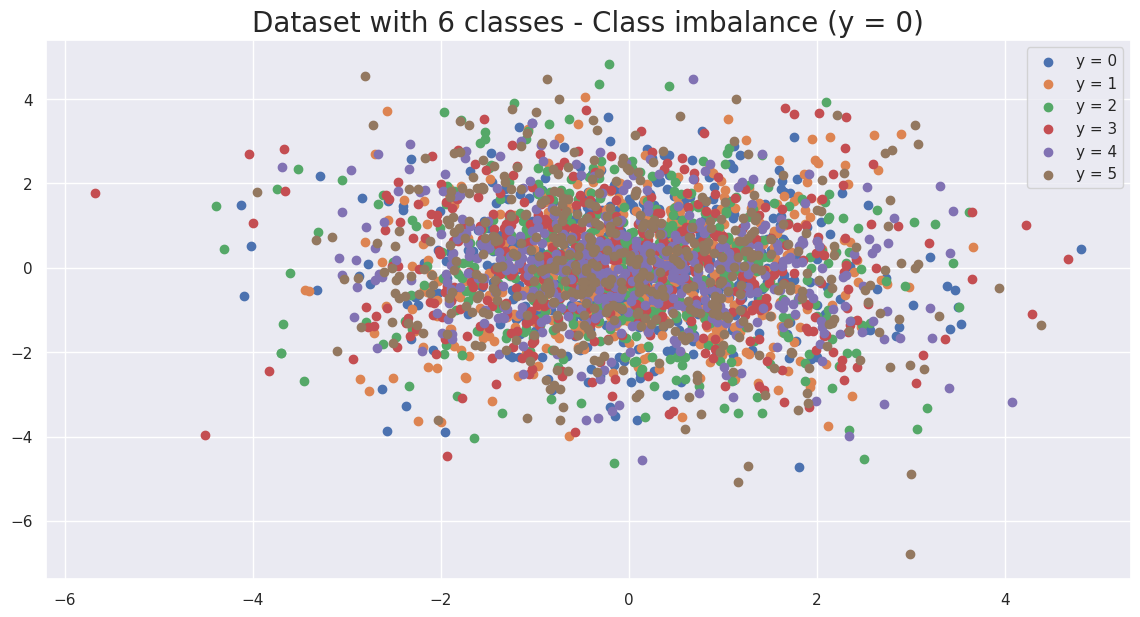

/tmp/ipykernel_10131/3381427439.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['car_id'] = df[['riders', 'year_to_start', 'car_rating', 'target_2', 'car_id']].sum(axis=1).map(hash_f).astype(str)


10 10 4250 4250
car_info (4250, 10) 4250


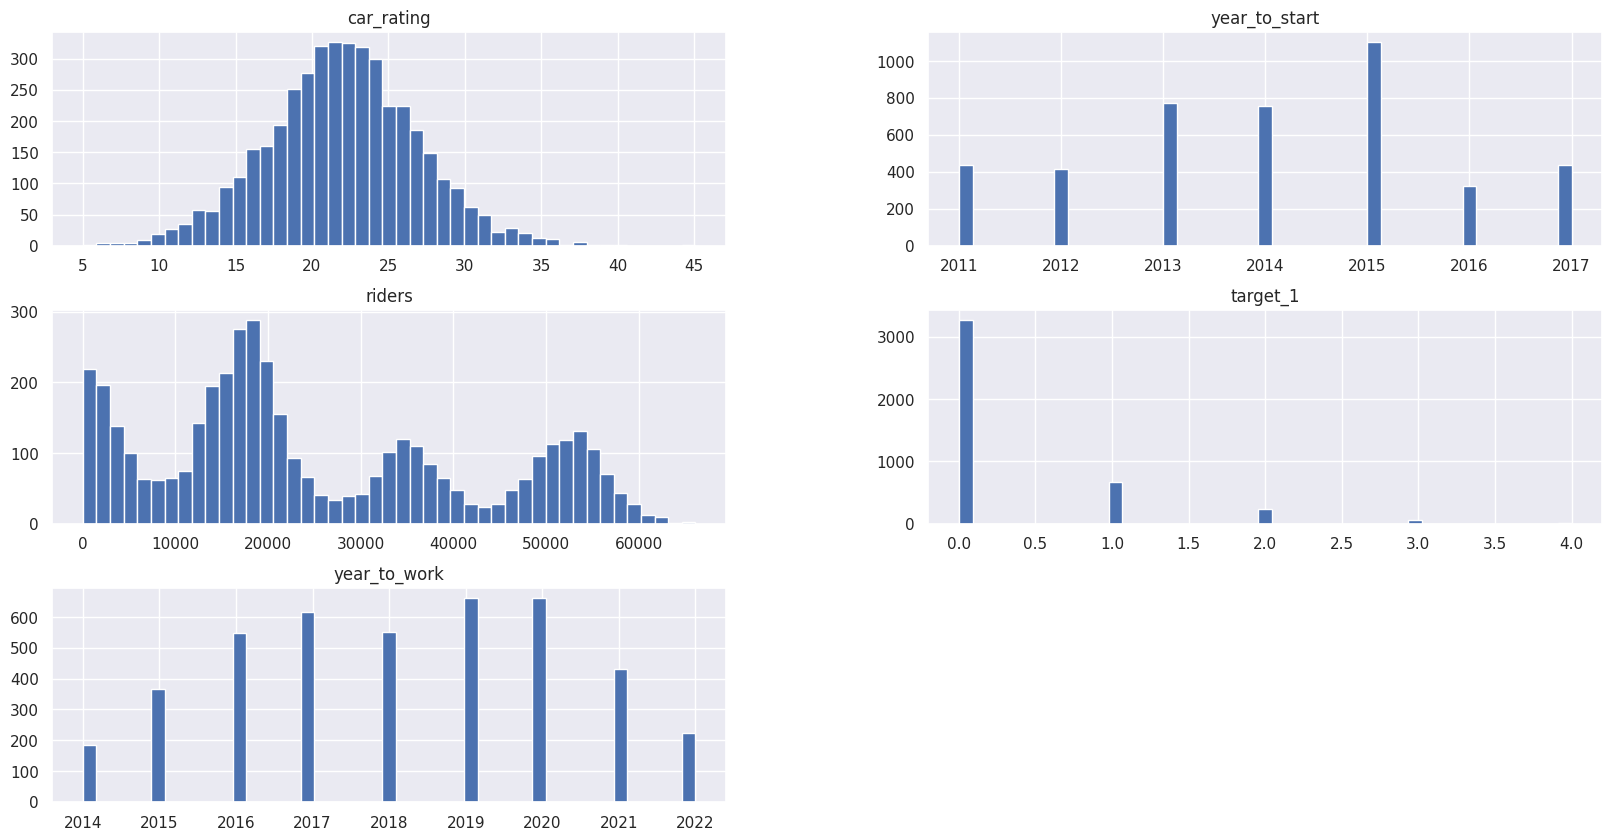

In [9]:
if generate:
        
#     # Это будет Питер
#     X_blobs_spb, y_blobs_spb = make_blobs(n_samples = generation_config_spb['n_samples'],
#                                   centers = generation_config_spb['n_clusters'],
#                                   cluster_std = generation_config_spb['cluster_std'],
#                                   center_box = generation_config_spb['center_box'],
#                                   n_features = generation_config_spb['n_features'],
#                                   random_state = generation_config_spb['random_state'],
#                              )
#     # print(y_blobs_spb)
#     y_blobs_spb+=1
#     # print(y_blobs_spb)

#     # Это будет Москва
#     X_blobs_msk, y_blobs_msk = make_blobs(n_samples = generation_config['n_samples'],
#                                   centers = generation_config['n_clusters'],
#                                   cluster_std = generation_config['cluster_std'],
#                                   center_box = generation_config['center_box'],
#                                   n_features = generation_config['n_features'],
#                                   random_state = generation_config['random_state'],
#                                  )

#     # print(y_blobs_msk)
#     y_blobs_msk-=1
#     # print(y_blobs_msk)

#     X_blobs = np.concatenate((X_blobs_msk, X_blobs_spb), axis=0)
#     y_blobs = np.concatenate((y_blobs_msk, y_blobs_spb), axis=0)

#     cities = np.concatenate((np.array([0]*y_blobs_msk.shape[0]), np.array([1]*y_blobs_spb.shape[0])), axis=0)

#     print(X_blobs.shape)
#     plt.figure(figsize=(12,9))
#     plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='plasma')
#     plt.legend(y_blobs)
#     plt.show()


    n_informative = 6
    X, y = make_classification(
        n_classes = 9,
        n_samples=generation_config_spb['n_samples'], 
        n_features=generation_config_spb['n_features'],
        n_informative = n_informative,
        # n_redundant=n_features - ,
        n_clusters_per_class=6,
        class_sep = -0.01,
        # weights=[0.5],
        random_state=42
    )

    df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
    cols = ['car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'car_id', 'model', 'target_1', 'target_2']
    df.columns = cols
    
    # Построим примеры
    plot(df=df, x1='car_type', x2='car_rating', y='target_2', title='Dataset with 6 classes - Class imbalance (y = 0)')

    
    # df = pd.DataFrame(X_blobs, columns = cols)
    # df['main_city'] = cities
    
    
    df['target_1'] = df['target_1'].clip(lower = 0, upper = df['target_1'].max()*0.8).astype(int)


    # df['target_2'] = y_blobs

    change_target = lambda x : target_classes.get(x, x)
    df['target_2'] = df['target_2'].apply(change_target)


    hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters), str(hash(x))[:8], random.choice(string.ascii_letters), random.choice(string.ascii_letters))
    df['car_id'] = df[['riders', 'year_to_start', 'car_rating', 'target_2', 'car_id']].sum(axis=1).map(hash_f).astype(str)


    models = list(car_model_conditions.keys())
    p = [1/car_model_conditions[m]['rating_min'] for m in car_model_conditions.keys()]
    p = [i/sum(p) for i in p]
    get_models = lambda x: np.random.choice(models, p = p)
    
    df['year_to_start'] += np.random.random(size=df.shape[0])/3
    df['riders'] += np.random.random(size=df.shape[0])/3
    df['model'] += np.random.random(size=df.shape[0])/3
    df['model'] = df['model'].apply(get_models)
    # df['model'] = pd.cut(df['model'], len(car_model_conditions.keys()), labels = car_model_conditions.keys()).astype(str)

    # fuel_types = ['diesel', 'gas', 'petrol', 'electro']
    # df['fuel_type'] = pd.cut(df['fuel_type'], len(fuel_types), labels = fuel_types)

    get_val = lambda x: car_model_conditions[x]['fuel_types']
    df['fuel_type'] = df['model'].apply(get_val)

    # car_types = ['luxury', 'standart_1','standart_2', 'sport', 'economy',  'business',]
    # df['car_type'] = pd.cut(df['car_type'], len(car_types), labels = car_types)

    get_val = lambda x: car_model_conditions[x]['car_type']
    df['car_type'] = df['model'].apply(get_val)


    cat_type_dict = {'standart_1' : 'standart', 'standart_2' : 'standart'}
    cat_type_func = lambda x: cat_type_dict.get(x, x)
    df['car_type'] = df['car_type'].apply(cat_type_func)

    df['car_rating'] = df['car_rating'] + np.random.random(size=df.shape[0])/3
    df['car_rating']+= df['car_rating'].min()
    df['car_rating'] = df['car_rating'] // (df['car_rating'].max()*0.02) / 10

    get_val = lambda x: np.random.choice(car_model_conditions[x]['year_to_work'])
    df['year_to_work'] = df['model'].apply(get_val).astype(int)
    df['year_to_work'] -= np.random.choice([-1, 0, 1], size = df.shape[0])

    df['target_2'] = df.apply(add_model_pattern, axis=1)
    
    get_val = lambda x: car_model_conditions[x]['year_to_start'] - np.random.choice([0, 1, 2, 3, 4], p = [0.3, 0.2, 0.2, 0.15, 0.15])
    df['year_to_start'] = df['model'].apply(get_val)

    # years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    # df['year_to_start'] = pd.cut(df['year_to_start'], len(years_list), labels = years_list).astype(int)

    df['riders'] = df['riders'] - np.random.random(size=df.shape[0])/4
    df['riders'] = ((df['year_to_start'] - 2015)*365*24*2 + 3_000*df['riders'])
    df['riders'] = abs(df['riders'] - df['riders'].mean())
    df['riders'] = df['riders'].clip(lower = 1).astype(int)

    print(df['car_id'].str.len().min(), df['car_id'].str.len().max(),  df['car_id'].nunique(), df.shape[0])
    print('car_info', df.shape, df['car_id'].nunique())

    df.hist(figsize = (20, 10), bins=45)

    car_info = df

    car_info.to_csv('../data/tmp_car_info.csv', index=False)

    df.describe()
    gc.collect()

    # TODO добавить зависимость таргетов
    
else:
    
    car_info = pd.read_csv('../data/tmp_car_info.csv')

In [10]:
# sns.displot(data = df, x = 'riders', y = 'car_rating', hue = 'main_city', aspect=3);

In [11]:
# # TODO Добавить дисбаланс классов
# df['target_2'].value_counts()
# df['target_2'].unique()  
# df['year_to_work'].value_counts()

In [12]:
# car_info['car_type'].value_counts() #.head()
# car_info.columns

In [13]:
# df['model'].value_counts()

In [14]:
# car_info.head()

# Сгенерируем rider_info

* `user_id` - ID пользователя

-----------

* `first_ride_date` - дата первой поездки

-----------
* `sex` - пол
* `age` - возвраст (средний возраст мужчин - 48 лет, женщин - 45)
* `user_rating` - рейтинг
* `user_rides` - количество поездок
* `user_time_accident` - количество инцидентов

In [15]:
# Штрафы
# Не следует забывать о том, что в каршеринге действуют строгие правила, нарушение которых может повлечь за собой штрафные санкции. К одним из них относятся:

# курение в салоне (2000) руб;
# загрязнение салона (2000 руб);
# передача руля третьему лицу (100 000 руб);
# перевозка животных без специальной переноски (2000 руб);
# дрифтинг (100 000 руб);
# парковка на газоне/тротуаре (100 000 руб);

(15153, 8)


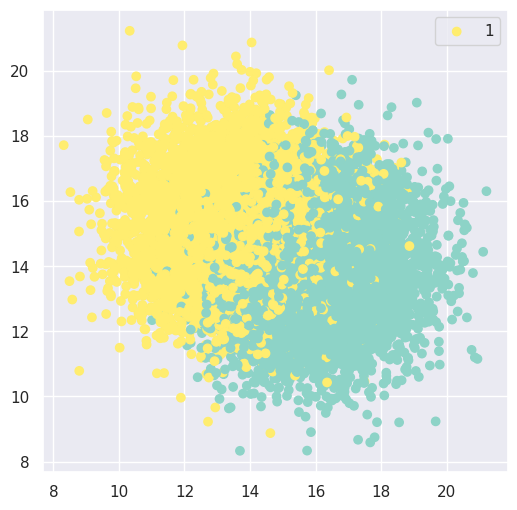

10 10 15153 15153
rider_info


age  user_rating  user_rides  user_time_accident     user_id  sex  \
0   27          9.2         865                  19  Q17437965s    1   
1   46          8.2        2116                  47  Z12362316i    0   
2   59          8.0         947                   5  N11098715w    0   
3   37          7.2          18                   4  y12618125U    0   
4   39          8.4         428                   8  U14375829U    0   

   eng_check first_ride_date  
0      False        2019-4-2  
1       True      2021-11-19  
2      False       2021-1-15  
3      False      2019-11-20  
4      False       2019-7-23

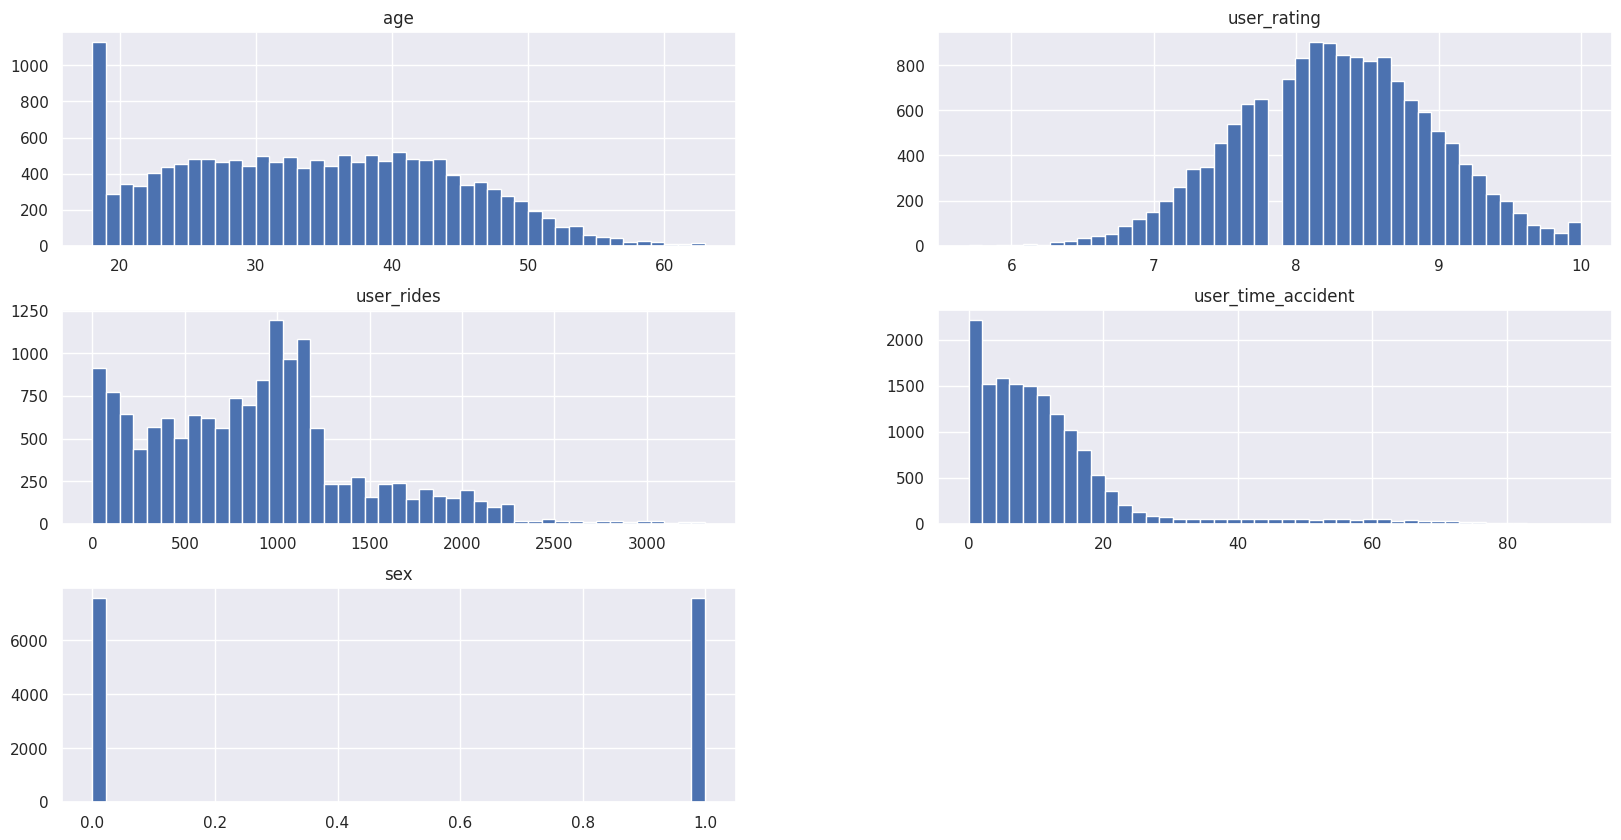

In [16]:
generation_config = { 
                     'n_samples': 15_153, 
                     'n_clusters':  2, 
                     'n_features' : 8,
                     'cluster_std' : 1.5,
                     'center_box' : (13, 17),
                     'random_state' : 7575,
                     }


if generate:    

    X_blobs, y_blobs = make_blobs(n_samples = generation_config['n_samples'],
                                  centers = generation_config['n_clusters'],
                                  cluster_std = generation_config['cluster_std'],
                                  center_box = generation_config['center_box'],
                                  n_features = generation_config['n_features'],
                                  random_state = generation_config['random_state'],
                                 )


    print(X_blobs.shape)
    plt.figure(figsize=(6, 6))
    plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='Set3')
    plt.legend(y_blobs)
    plt.show()


    cols = ['year', 'month','day', 'age', 'user_rating', 'user_rides', 'user_time_accident', 'user_id']
    df = pd.DataFrame(X_blobs, columns = cols)
    df['sex'] = y_blobs

    hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters), str(hash(x))[:8], random.choice(string.ascii_letters))
    df['user_id'] = df[['year', 'month','day', 'age', 'user_rating', 'user_rides', 'user_id']].sum(axis=1).map(hash_f).astype(str)


    df.describe()

    df['age'] = df['age'] // (df['age'].max()*0.01) // 1
    df['age'] = df['age'] - 34
    df['age'] = df['age'].clip(lower = 18, upper = df['age'].max()*0.98).astype(int)

    df['user_rating'] += np.random.random(size = df.shape[0])
    df['user_rating'] = (df['user_rating'] // (df['user_rating'].max()*0.01)) / 10
    df['user_rating'] += 1
    df['user_rating'] = df['user_rating'].clip(lower = 0, upper = 10)
        
    
    years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    df['year'] = pd.cut(df['year'], len(years_list), labels = years_list).astype(int)
    df['month'] = pd.qcut(df['month'], q = 12, labels = range(1, 13)).astype(int)
    df['day'] = pd.qcut(df['day'], q = 30, labels = range(1, 31)).astype(int)

    df['user_rides'] =((df['year'] - 2017)*365*24*1.2 + \
                   df['month']*30*24*1.6 + \
                   df['day']*24*1.8 + \
                   df['user_rides'] + df['user_rating']*5
                      ).astype(int)
    
    df['user_rides'] = abs(30*(df['user_rides'] - df['user_rides'].mean()) / 300 ).astype(int)

    df['user_time_accident'] = (df['user_time_accident']*7 + df['user_rides'] / 14_000)
    
    df['user_time_accident'] = df['user_time_accident'] / (df['user_rating'] / 4 )
    
    df['user_time_accident'] = abs(df['user_time_accident'] - df['user_time_accident'].mean() - df['user_rating']) 
    
    df['user_time_accident'] = df['user_time_accident'].clip(lower = 0, upper = df['user_time_accident'].max()*0.9).astype(int)

    tmp = np.random.random(size = df.shape[0]) > 0.90
    df['eng_check'] = tmp
    df['user_time_accident'] += (tmp)*(np.random.random(size = df.shape[0])*60 + np.random.randint(10)).astype(int)
    
    df['first_ride_date'] = df['year'].astype(str) + "-" +  df['month'].astype(str) + "-" +  df['day'].astype(str)
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)

    print(df['user_id'].str.len().min(), df['user_id'].str.len().max(),  df['user_id'].nunique(), df.shape[0])

    
    rider_info = df

    rider_info.drop('eng_check', axis=1).to_csv('../data/tmp_driver_info.csv', index=False)
    
else:
    
    rider_info = pd.read_csv('../data/tmp_driver_info.csv')
    

rider_info.hist(figsize = (20, 10), bins=45)
print('rider_info')
gc.collect()
rider_info.head()
    

In [17]:
# tmp = (np.random.random(size = 20) > 0.90)*(np.random.random(size = 20)*30).astype(int)

# fix_info

* `car_id`
* `worker_id`
* `five_previous_user_id`
----------------
* `time`
* `work_type`
* `destroy_degree`
* `work_duration`

In [18]:
# TODO пофиксить вот это
# 'Recall:class=6': # 'engine_ignition' 
# 'Recall:class=5': # engine_check
# 'Recall:class=3': # gear_stick
# 'Recall:class=8': # electro_bug

def fix_pattern_1(x):  # Закладываем инфу в ремонт
    
    target = x.target_2
    work_duration = x.work_duration
    
    if target in ['electro_bug']:
        work_duration = min(48, x.work_duration)
            
    return work_duration 

def fix_pattern_2(x):  # Закладываем инфу в rating
    
    target = x.target_2
    destroy_degree = x.destroy_degree
    
    if target in ['engine_ignition', 'engine_check']:
        destroy_degree = min(5, x.destroy_degree)
        
        
    return destroy_degree 

def fix_pattern_3(x): # Заложим паттерн на класс engine_overheat wheel_shake
    target = x.target_2
    work_type = x.work_type
    
    # 'Recall:class=7': 0.31666666666666665, wheel_shake
# 'Recall:class=4': 0.39344262295081966, engine_fuel
# 'Recall:class=3': 0.3114754098360656, gear_stick
    
    if target in ['gear_stick', 'engine_fuel']:
        if x.work_type in ['oil_change']:
            if np.random.random() > 0.1:
                work_type = np.random.choice(['refuel_reparking', 'refuel', 'reparking', 'repair', 'refuel_check'])
    
    if target in ['engine_overheat', 'wheel_shake']:
        if x.work_type in ['oil_change', 'refuel_check', 'repair']:
            if np.random.random() > 0.1:
                work_type = np.random.choice(['refuel_reparking', 'refuel', 'reparking'])
    
    return work_type    
        
        

tqdm.pandas()

(146000, 10)


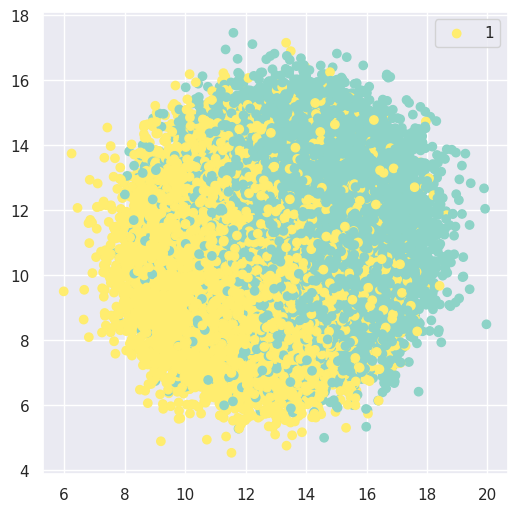

  0%|          | 0/146000 [00:00<?, ?it/s]

  0%|          | 0/146000 [00:00<?, ?it/s]

worker_id 546 146000
car_id 4250 146000
fix_info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   work_type       146000 non-null  category
 1   destroy_degree  146000 non-null  float64 
 2   work_duration   146000 non-null  int64   
 3   car_id          146000 non-null  object  
 4   worker_id       146000 non-null  object  
 5   fix_date        146000 non-null  object  
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 6.8+ MB


car_id worker_id         fix_date     work_type  destroy_degree  \
0  C16209094m        ZT   2020-6-20 2:14     reparking             1.0   
1  G-1559355l        PS   2020-2-9 20:25        repair             3.5   
2  v-1144396k        EM    2019-8-24 7:1     reparking             1.0   
3  P14360916q        XO   2019-8-10 9:29     reparking            10.0   
4  b13819346G        OH  2020-11-12 5:22  refuel_check             1.0   

   work_duration  
0             20  
1              1  
2             27  
3             62  
4             22

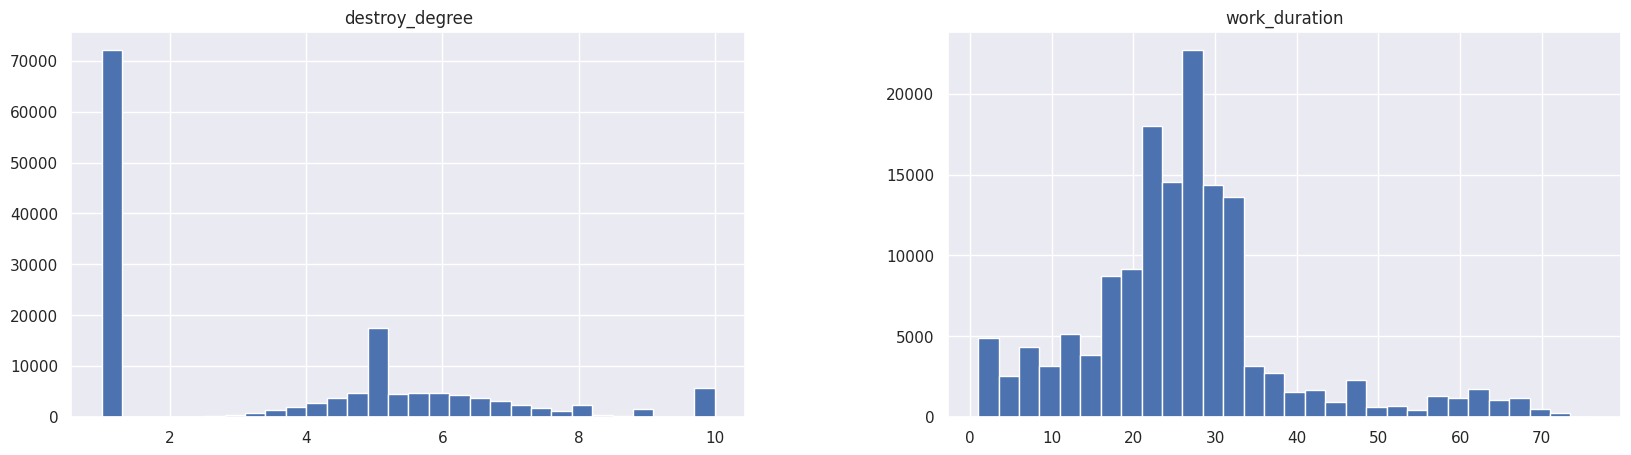

In [19]:
if generate:    

    generation_config = { 
                     'n_samples': int(((10_000*365*4 / 50)/ 10)*0.5)*10, 
                # машины*дни*годы / рабочие / скорость обслуживания * необходимая частота обслуживания 
                     'n_clusters':  2, 
                     'n_features' : 10,
                     'cluster_std' : 1.5,
                     'center_box' : (10, 15),
                     'random_state' : 7575,
                     }

    # Это будет Питер
    X_blobs, y_blobs = make_blobs(n_samples = generation_config['n_samples'],
                              centers = generation_config['n_clusters'],
                              cluster_std = generation_config['cluster_std'],
                              center_box = generation_config['center_box'],
                              n_features = generation_config['n_features'],
                              random_state = generation_config['random_state'],
                             )

    print(X_blobs.shape)
    plt.figure(figsize=(6, 6))
    plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap ='Set3')
    plt.legend(y_blobs)
    plt.show()

    cols = ['year', 'month', 'day', 'hour', 'mins', 'work_type', 'destroy_degree', 'work_duration', 'car_id', 'worker_id']
    df = pd.DataFrame(X_blobs, columns = cols)
    df['sex'] = y_blobs

    years_list = ['refuel_reparking', 'refuel', 'reparking', 'repair', 'refuel_check', 'oil_change']
    df['work_type'] = pd.cut(df['work_type'], len(years_list), labels = years_list)

    years_list = [2017, 2018, 2020, 2019, 2021, 2022]
    df['year'] = pd.cut(df['year'], len(years_list), labels = years_list).astype(int)
    df['month'] = pd.qcut(df['month'], q = 12, labels = range(1, 13)).astype(int)
    df['day'] = pd.qcut(df['day'], q = 30, labels = range(1, 31)).astype(int)

    df['hour'] = pd.qcut(df['hour'], q = 24, labels = range(24)).astype(int)
    df['mins'] = pd.qcut(df['mins'], q = 60, labels = range(60)).astype(int)

    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    df['destroy_degree'] += np.random.random(size = len(df))*10 + np.random.random(size = len(df))*25 + np.random.random(size = len(df))*55
    
    df['destroy_degree'] = df['destroy_degree'] // (df['destroy_degree'].max()*0.01) / 10
    
    df['destroy_degree'] = df['destroy_degree'].values*df['work_type'].isin(['repair'])
    
    df['destroy_degree'] += np.random.choice([0, 1], size = df.shape[0], p = [0.92, 0.08])*np.random.randint(8, 11, size = df.shape[0])
    df['destroy_degree'] = df['destroy_degree'].clip(lower = 1, upper = 10)
    
    df['work_duration'] = df['work_duration'] + df['destroy_degree']*10 + abs(df['hour'] - 14)

    df['work_duration'] = abs(df['work_duration'] - df['work_duration'].mean()).astype(int)
    df['work_duration'] = df['work_duration'].clip(lower = 1)

    names, fios = 'BCDFGHJKLMNOPRSTVWXYZ', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    hash_f = lambda x: '{}{}'.format(random.choice(fios), random.choice(names))
    df['worker_id'] = df[['year']].sum(axis=1).map(hash_f).astype(str)

    
    cars_ids = car_info['car_id'].unique().tolist()
    cycler = cycle(cars_ids)
    df['car_id'] = df['sex'].apply(lambda x: next(cycler))
    # wheel_shake
    
    # TODO завимость от таргета
    cols = ['car_id', 'model', 'car_type', 'target_2']
    df = df.merge(car_info[cols], on = 'car_id', how = 'left')
    
    df['work_duration'] = df.progress_apply(fix_pattern_1, axis=1)
    df['destroy_degree'] = df.progress_apply(fix_pattern_2, axis=1)
    
    # cars_ids = car_info['car_id'].unique().tolist()
    # hash_f = lambda x: '{}'.format(random.choice(cars_ids))
    # df['car_id'] = df[['car_id']].sum(axis=1).map(hash_f).astype(str)

    df['fix_date'] = df['year'].astype(str) + "-" +  df['month'].astype(str) + "-" +  df['day'].astype(str)
    df['fix_date'] = df['fix_date'].astype(str) + " " +  df['hour'].astype(str) + ":" +  df['mins'].astype(str)

    df.drop(['year', 'month', 'day', 'hour', 'mins', 'sex', 'model', 'car_type', 'target_2'], axis=1, inplace=True, errors = 'ignore')

    print('worker_id', df['worker_id'].nunique(), df.shape[0])
    print('car_id',    df['car_id'].nunique(), df.shape[0])

    
    df.hist(figsize = (20, 5), bins=30)
    print('fix_info')
    df.head()

    cols_order = ['car_id', 'worker_id', 'fix_date', 'work_type', 'destroy_degree', 'work_duration']
    fix_info = df[cols_order]

    fix_info.to_csv('../data/fix_info.csv', index=False)

    df.describe()
    df.info()
    
else:
    fix_info = pd.read_csv('../data/fix_info.csv')
    df = fix_info
    
fix_info.head()

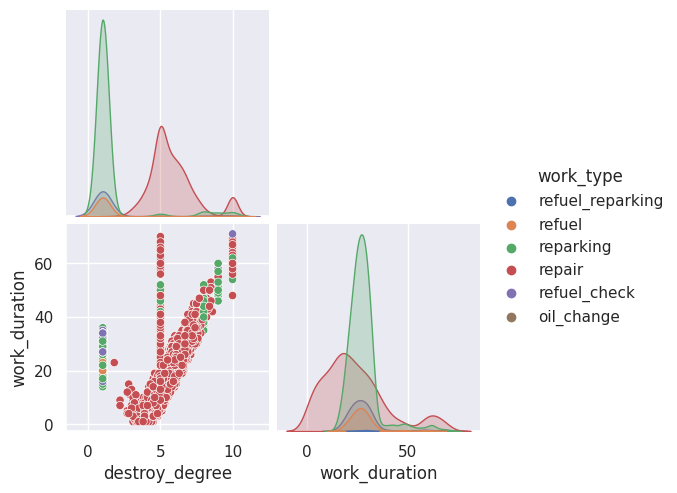

In [20]:
ids_car = fix_info['car_id'].unique()[:100]
tmp = fix_info[fix_info['car_id'].isin(ids_car)]
sns.pairplot(data = tmp, hue = 'work_type', corner=True);

In [21]:
# df.info()
# df.groupby('work_type')['destroy_degree'].agg(['sum', 'count'])

In [22]:
# df.groupby(['car_id', 'work_type'], as_index=False)['destroy_degree'].count()['destroy_degree']#.min()

In [23]:
# df.destroy_degree.value_counts()


In [24]:
df.head()

work_type  destroy_degree  work_duration      car_id worker_id  \
0     reparking             1.0             20  C16209094m        ZT   
1        repair             3.5              1  G-1559355l        PS   
2     reparking             1.0             27  v-1144396k        EM   
3     reparking            10.0             62  P14360916q        XO   
4  refuel_check             1.0             22  b13819346G        OH   

          fix_date  
0   2020-6-20 2:14  
1   2020-2-9 20:25  
2    2019-8-24 7:1  
3   2019-8-10 9:29  
4  2020-11-12 5:22

<AxesSubplot: >

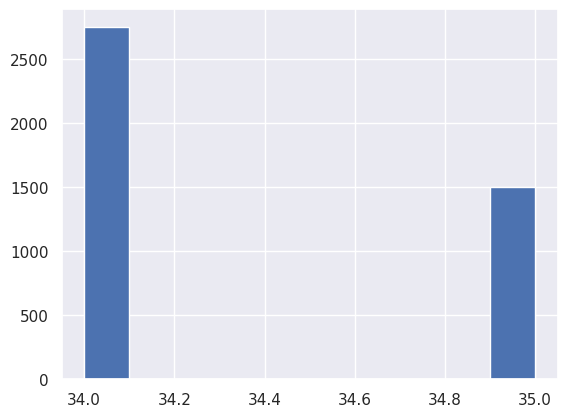

In [25]:
# assert False
df['car_id'].value_counts().hist()

In [26]:
# TODO дозаправка и перегонка происходят чаще ночью


In [27]:
# df = pd.DataFrame(X_blobs)
# df.describe()

# Генерируем поездки - rides_info

In [28]:
# n_1 = 140 + np.random.randint(30)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=1, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1)
# rw = np.concatenate((part_1, part_2))

# plt.plot(rw)

In [29]:
# n_1 = 120 + np.random.randint(20)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1) + 20
# rw = np.concatenate((part_1, part_2))
# print(n_1)
# plt.plot(rw)

In [30]:
# n_1 = 100 + np.random.randint(40)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=-1, std=1).reshape(1, -1)[0] + max(part_1)

# out_1= np.random.randint(len(part_2))
# part_2[out_1]-=50
# out_2 = np.random.randint(len(part_2))
# part_2[out_2]-=50

# feature = n_1 + max(out_1, out_2)
# rw = np.concatenate((part_1, part_2))

# plt.plot(rw)

In [31]:
# n_1 = 70 + np.random.randint(70)
# n_2 = 180 - n_1
# part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = 0, std=1).reshape(1, -1)[0]
# part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = 0, std=1).reshape(1, -1)[0] + min(part_1)

# out_s1 = np.random.randint(60, size = len(part_2))
# out_s2 = np.random.randint(60, size = len(part_2))
# part_2 -= out_s1
# part_2 += out_s2
# feature = n_1 
# rw = np.concatenate((part_2, part_1))


# print(feature)
# plt.plot(rw)

In [32]:
def make_crew(x):
    if x < 0: return abs(x)
    else: return x + 3*np.random.randint(5)*np.random.randint(2)*np.random.random()
    
    
def get_user_by_car(x):
    
    '''
    Предлагаемые машины пользователям в зависит от самого пользователя.
    Теслы предлгаются только самым "хорошим"
    Бехи и спорткары тоже только самым хорошим
    Электрокары можно получить проще
    
    '''
    car_id = x.car_id
    target = x.target_2
    # TODO rider_info eng_check
    
    car_model = car_info[car_info['car_id'] == car_id]['model'].values[0]     
    car_tmp = car_model_conditions[car_model]
    
    if target in ['engine_fuel', 'wheel_shake', 'another_bug', 'engine_check']:
        if np.random.random() > 0.5:
            # В случае этих причин иногда возвращать людей с выбросами
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == True)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] >= np.random.choice([5, 10, 20]) )
                                 ]['user_id'].unique()
        else:
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] <= np.random.choice([10, 40], p = [0.1, 0.9]) )
                                 ]['user_id'].unique()
            
    elif target in ['engine_overheat', 'gear_stick']: 
        if np.random.random() > 0.5:
            # В случае этих причин иногда возвращать людей с выбросами
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['user_rating'] <= max(8, car_tmp['rating_min']))
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            &(rider_info['user_time_accident'] >= np.random.choice([3, 5, 7]) )
                                 ]['user_id'].unique() 
        else:
            user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                            &(rider_info['age'] >= car_tmp['age_min'])
                            &(rider_info['eng_check'] == False)
                            &(rider_info['user_rides'] >= car_tmp['rides_min'])
                            # &(rider_info['user_time_accident'] >= 5)
                                 ]['user_id'].unique() 
            
            
            
    else:
        user_ids = rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
                        &(rider_info['age'] >= car_tmp['age_min'])
                        &(rider_info['eng_check'] == False)
                        &(rider_info['user_rides'] >= car_tmp['rides_min'])
                        &(rider_info['user_time_accident'] <= np.random.choice([13, 25, 27, 40], p = [0.6, 0.2, 0.15, 0.05]))
                             ]['user_id'].unique() 

    if len(user_ids) == 0: 
        user_ids = rider_info[(rider_info['user_rating'] >= min(car_tmp['rating_min'], np.random.choice([4, 5, 7, 6])))
                &(rider_info['age'] >= car_tmp['age_min'])
                &(rider_info['eng_check'] == False)
                &(rider_info['user_rides'] >= car_tmp['rides_min'])
                &(rider_info['user_time_accident'] <= np.random.choice([13, 25, 27, 40], p = [0.6, 0.2, 0.15, 0.05]) )
                             ]['user_id'].unique()
        
        print(car_tmp, car_model)
        print(car_id, '--------', target)
        assert len(user_ids) != 0
        return random.choice(user_ids)
    else:
        return random.choice(user_ids)
     
    

def generate_features(X):
    
    car_id = X.car_id
    user_id = X.user_id

    ride_cost = X.ride_cost
    ride_duration = X.ride_duration
    
    distance = X.distance
    stop_times = abs(X.stop_times)
    refueling = X.refueling*0
    speed_avg = X.speed_avg
    
    # Car info
    # TODO исправить 
#     tmp = car_info[car_info['car_id'] == car_id]
    
    car_type = X.car_type #tmp['car_type'].values[0]
    fuel_type = X.fuel_type # tmp['fuel_type'].values[0]
    # car_rating = X.car_rating # tmp['car_rating'].values[0]
#     year_to_start = tmp['year_to_start']
#     riders = tmp['riders']
#     # main_city = tmp['main_city']
    
    car_shift = car_type_shift[car_type]
    
    # Driver info 
#     user_time_accident = driver_info[driver_info['user_id'] == user_id]['user_time_accident']
#     user_rides = driver_info[driver_info['user_id'] == user_id]['user_rides']
#     user_rating = driver_info[driver_info['user_id'] == user_id]['user_rating']
#     age = driver_info[driver_info['user_id'] == user_id]['age']
    
    
    if fuel_type == 'electro':
        refueling = refueling*0
    
#     target_1 = tmp['target_1'].values[0]
    target_2 = X.target_2 #tmp['target_2'].values[0]
    
    rating = X.rating
    hour = X.hour
    speed_max = X.speed_max
    
    # TODO использовать car_rating !

    distance = distance/3 + ride_duration
    
    if random.choice([10, 11, 12, 13]) < hour <  random.choice([18, 19, 20, 21]):
        rating = rating - random.choice([0.5, 2.5, 1.5, 3.5, 0])
        speed_avg = max(0.9*distance/(ride_duration + 2) + 10*speed_avg/(stop_times+2), random.choice(range(25, 52)))
    else:
        speed_avg = max(distance/(ride_duration + 2) + 10*speed_avg/(stop_times + 1), random.choice(range(30, 55)))
    
    speed_avg = min(100, speed_avg)
    speed_avg = max(3, speed_avg)
    
    if target_2 in ['gear_stick', 'engine_check', 'engine_check'] and np.random.random() > 0.55: # Что-то классические
        speed_avg = max(speed_avg, random.choice([30, 10, 20, 50])*(0.2 + np.random.random()), 5)
        
    elif target_2 in ['wheel_shake', 'another_bug',] and np.random.random() > 0.55: # Что-то, что приводит к частым остановкам
        speed_max = max(speed_max, random.choice(range(120)), 5, speed_avg*(1 + np.random.random()))
        ride_duration = ride_duration + random.choice([30, 10, 20, 40])*(0.2 + np.random.random())
        stop_times = stop_times + np.random.choice(a=list(range(20)), p = [2*(20-i)/20**2 - 0.05/20 for i in list(range(20))])
        
    elif target_2 in ['engine_overheat', 'engine_fuel', 'engine_ignition', 'electro_bug'] and np.random.random() > 0.55:
        speed_avg = max(speed_avg, random.choice(range(90)), 5)
        speed_max = max(speed_avg*(1 + np.random.random()), speed_max, random.choice(range(150)), 5) + random.choice([0, 0, 0, 0, 5, 15, 25, 35])*np.random.random()
        ride_duration = ride_duration + random.choice([30, 10, 20, 50])*np.random.random()
        rating = min(10, rating - random.choice([0.5, 2.5, 1.5, 3.5, 0]))   
        
        
    else:
        rating = min(10, rating + random.choice([0.5, 2.5, 1.5, 3.5, 0, 0]))                        
        speed_max = min(speed_avg + random.choice(range(5, 42)), speed_avg + random.choice(range(31, 63)))
    
    rating = max(0, rating)
    
    if target_2 in ['electro_bug']:
        out = (np.random.random() > 0.96)*10
    else:
        out = 0.1
        
    rating = min(10, rating + out)
    
    distance = distance + ride_duration*speed_avg
    ride_duration = int(ride_duration + int(stop_times*np.random.choice([3, 8, 9, 10, 11, 12, 13, 14, 20, 30, 60, 300])*np.random.random()))
    ride_duration = max(ride_duration, 2)
    
    speed_avg  = int(max(20, speed_avg))
    
    if car_type in ['business', 'premium']:
        if target_2 in ['wheel_shake']:
            ride_cost = int(ride_duration*np.random.choice([12, 13, 15, 20]) + ride_cost)
        else:
            ride_cost = int(ride_duration*np.random.choice([12, 13, 15, 20, 30, 50]) + ride_cost)
    else:
        ride_cost = int(ride_duration*np.random.choice([8, 9, 10, 11, 12, 13, 14, 16]) + ride_cost)
        
    
    return rating, speed_avg, speed_max, ride_duration, stop_times, ride_cost, distance



def get_targets(X):
    
    car_id = X.car_id
    tmp = car_info[car_info['car_id'] == car_id]

    target_1 = tmp['target_1'].values[0]
    target_2 = tmp['target_2'].values[0]
    
    return target_1, target_2

def get_ts_by_target(target):
    
    
    # TODO добавить переломы в engine и gear_stick
    feature_len = int(60*num_months)
    mu, std, intercept = target_dict[target]['mu'], target_dict[target]['std'],  target_dict[target]['intercept']
    
    
    if np.random.random()> 0.80:
        n_1 = 80 + np.random.randint(20)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=0.0001).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=0.0001).reshape(1, -1)[0] + max(part_1)
        rw = np.concatenate((part_1, part_2))
        feature = 80 + np.random.randint(30)
        return rw.tolist(), feature
    
    
    if target in ['engine_overheat', 'wheel_shake']: 
        if np.random.random() > 0.8:
            n_1 = 60 + np.random.randint(20)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)
            rw = np.concatenate((part_1, part_2))
            feature = n_1
        else:
            n_1 = 60 + np.random.randint(20)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)
            rw = np.concatenate((part_2, part_1)) 
            feature = feature_len - n_1
        
    
        
    elif target in ['engine_ignition', 'engine_fuel']:
        n_1 = 90 + np.random.randint(10)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1) + 5 + 10*np.random.random()
        rw = np.concatenate((part_1, part_2))
        feature = n_1
        
    elif target in ['engine_check']:
        if np.random.random() > 0.5:
            n_1 = 85 + np.random.randint(15)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1)

            out_1, out_2 = np.random.randint(n_2), np.random.randint(n_2)

            part_2[out_1] -= 50
            part_2[out_2] -= 50

            rw = np.concatenate((part_1, part_2))
            feature = n_1 + max(out_1, out_2)
            
        else:
            n_1 = 85 + np.random.randint(15)
            n_2 = feature_len - n_1
            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu=0, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu=mu, std=std).reshape(1, -1)[0] + max(part_1) + 5 + 10*np.random.random()
            rw = np.concatenate((part_1, part_2))
            
            feature = n_1
            if np.random.random() > 0.75:
                rw = np.concatenate((part_1, part_2))
            else:
                rw = np.concatenate((part_2, part_1))
                feature = feature_len - n_1 
            
    elif target in [ 'break_bug', 'gear_stick']:
        
        if np.random.random() > 0.60:
            mu = 0
            std = 0.001
            
        n_1 = 60 + np.random.randint(30)
        n_2 = feature_len - n_1
        part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
        part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

        out_s = np.random.randint(30, size = n_2)
        part_2 -= out_s
        
        feature = n_1 
        
        if np.random.random() > 0.5:
            rw = np.concatenate((part_1, part_2))
        else:
            rw = np.concatenate((part_2, part_1))
            feature = feature_len - n_1 
            
        
        rw = rw + intercept*np.random.random()
    
    elif target in ['another_bug', 'electro_bug']:
        if np.random.random() > 0.5:
            n_1 = 70 + np.random.randint(30)
            n_2 = feature_len - n_1

            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

            out_s1, out_s2 = np.random.randint(20, size = n_2), np.random.randint(20, size = n_2)

            part_2 -= out_s1
            part_2 += out_s2

            feature = n_1 

            rw = np.concatenate((part_1, part_2)) + intercept*np.random.random()
            
        else:
            n_1 = 70 + np.random.randint(30)
            n_2 = feature_len - n_1

            part_1 = random_walks(n_ts=1, sz=n_1, d=1, mu = mu, std=std).reshape(1, -1)[0]
            part_2 = random_walks(n_ts=1, sz=n_2, d=1, mu = mu, std=std).reshape(1, -1)[0] + min(part_1)

            out_s1, out_s2 = np.random.randint(20, size = n_2), np.random.randint(20, size = n_2)

            part_2 -= out_s1
            part_2 += out_s2

            feature = feature_len - n_1

            rw = np.concatenate((part_2, part_1)) + intercept*np.random.random()
        
    
    return rw.tolist(), feature


def add_pattern_by_target(x):  # Закладываем инфу в user_ride_quality
    
    target = x.target_2
    user_ride_quality = x.user_ride_quality
    
    target_shift = {
        'wheel_shake' : -0.15,
        'another_bug' : -0.4,
        'gear_stick'  : -0.7
    }
    
    if target in ['wheel_shake', 'another_bug', 'gear_stick']:
        if user_ride_quality < target_shift[target] and np.random.random() > 0.70:
            user_ride_quality = abs(user_ride_quality)
        else:
            user_ride_quality = user_ride_quality
            
        if target in ['wheel_shake']:
            if np.random.random() > 0.5:
                user_ride_quality  -= 5
                    
    if target in ['gear_stick']:
        if np.random.random() > 0.97:
            user_ride_quality = None
            
    if target in ['engine_fuel', 'engine_overheat']:
        if np.random.random() > 0.98:
            user_ride_quality +=  4 - np.random.random() + 2*np.random.random()
        
    if target in ['another_bug', 'gear_stick']:
        if np.random.random() > 0.9:
            if user_ride_quality != None:
                user_ride_quality -= 1
           
        
    return user_ride_quality 

def rating_pattern_by_target(x):  # Закладываем инфу в rating
    
    target = x.target_2
    rating = x.rating
    
    target_shift = {
        'wheel_shake'  :  -0.5,
        'another_bug'  :  -0.2,
        'gear_stick'   :  -1.0, 
        'engine_check' :  -0.7
    }
    
    if target in ['wheel_shake', 'another_bug', 'gear_stick', 'engine_check']:
        if rating > 2 and np.random.random() > 0.7:
            rating += target_shift[target]
    return rating 




def pattern_by_user(x):  # Закладываем инфу в rating
    target = x.target_2
    rating = x.rating
    
    user_rides_pattern = x.user_rides_pattern
    user_time_accident_pattern = x.user_time_accident_pattern
    speed_max = x.speed_max
    # if x.age_pattern
    
    if speed_max > 300 and target in ['engine_ignition']:
        speed_max = -1
        
    
    if target in ['engine_overheat', 'engine_ignition',  'engine_check', 'another_bug']:
        if np.random.random() > 0.85 and x.age_pattern < 35:
            speed_max += int(80*np.random.random() + 3)
        elif np.random.random() > 0.80 and user_time_accident_pattern > 2:
            speed_max += int(80*np.random.random() + 3)
            
        speed_max = min(150 + np.random.random()*50, speed_max)
            
 
    if target in ['electro_bug', 'another_bug']:
        if np.random.random() > 0.98:
            speed_max = None
        elif np.random.random() > 0.85 and user_time_accident_pattern > 3 and user_rides_pattern < 1600:
            speed_max += int(50*np.random.random() + 3)
            speed_max = min(speed_max, 200)
        
    if target in ['another_bug', 'gear_stick']:
        if x.age_pattern > 35 and np.random.random() > 0.8:
            speed_max -= speed_max/10 
    if speed_max!= None:
        speed_max = max(x.speed_avg + np.random.random()*5, speed_max)
    return speed_max 


def coast_pattern_by_user(x):  # Закладываем инфу в rating
    
    target = x.target_2
    
    # user_rides_pattern = x.user_rides_pattern
    # user_time_accident_pattern = x.user_time_accident_pattern
    ride_cost = x.ride_cost
    
    if target in ['another_bug', 'electro_bug']:
        if np.random.random() > 0.85:
            ride_cost *= 0.93
            
    return ride_cost 

def deviation_normal_pattern(x):
    
    target = x.target_2
    deviation_normal = x.deviation_normal
    crit_sum = x.crit_sum
    worker_uniq = x.worker_uniq
    
    if target in ['electro_bug', 'engine_check', 'another_bug', 'gear_stick', 'wheel_shake']:
        if np.random.random() > 0.95 and x.crit_sum > 5:
            deviation_normal += int(6*np.random.random() + 1)
        elif np.random.random() > 0.95 and worker_uniq > 4:
            deviation_normal += int(6*np.random.random() + 1)
        elif np.random.random() > 0.97:
            deviation_normal -= int(10*np.random.random() + 1)
        
    return deviation_normal 

    

In [33]:
# car_info['target_2'].unique() 

In [34]:
from tslearn.generators import random_walks
from itertools import cycle

user_ids = rider_info['user_id'].unique().tolist()
cars_ids = car_info['car_id'].unique().tolist()

rider_hash = lambda x = -1: random.choice(user_ids)
car_hash = lambda x = -9999: random.choice(cars_ids)
hash_f = lambda x: '{}{}{}'.format(random.choice(string.ascii_letters),
                                   str(hash(x))[:7], random.choice(string.ascii_letters))

# TODO зашить падение тренда через заранее сгенерированные фичи кластера поездки

# cars_ids = cars_ids[:1500] #
# cars_ids = np.random.choice(cars_ids, size = 500, replace = False)# #cars_ids[:500]

rides_info = {'user_id' : [], 'car_id': [], 'ride_id' : [], 'ride_duration' : [],
             'stop_times' : [], 'speed_max' : [],'speed_avg' : [], 'rating' : [], 'ride_cost' : [],
             'refueling' : [], 'ride_duration' : [], 'hour' : [], 'target_2' : [], 'distance' : [],
              'user_time_accident' : []}

N_riders = len(cars_ids)*int(30*num_months*2) # cars X days X months X logs


generation_config = { 
                     'n_samples': N_riders, 
                     'n_clusters':  1, 
                     'n_features' : 8,
                     'cluster_std' : 1,
                     'center_box' : (-10, 10),
                     'random_state' : 7575,
                     }


cols = ['ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'rating', 'stop_times', 'distance', 'refueling']
techical = ['accident', 'anomaly', 'speed_max']
car_type_shift = {'business'  : 4, 'economy' : 3.5, 'standart' : 3.9, 'sport' : 4.5 , 'luxury' : 4, 'premium' : 3.99}


target_dict = { 'another_bug'    :   {'mu' : -0.0, 'std' : 6.5/3,  'intercept' :  6}, # Что-то классические
                'electro_bug'    :   {'mu' : .001, 'std' : 6.5/3,  'intercept' :  5}, # Что-то классические. Связанное с низкими рейтингами из-за вырубания машин.

                'wheel_shake'   :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Что-то классические, аномалии, дрожание руля. 
                'gear_stick'    :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Машина работает аномально
                'break_bug'     :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # Машина начинает хуже тормозить

                'engine_fuel'   :     {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 7},  # Тут должен быть два сдвига. Сдвиг от пика будем определять время до поломки
                'engine_check'   :    {'mu' : -0.10, 'std' : 6.5/3,  'intercept' : 5}, # 
                'engine_overheat'   : {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 7}, # Тут просто закончился антифриз
                'engine_ignition'   : {'mu' : -0.17, 'std' : 6.5/3,  'intercept' : 5} # Что-то, что приводит к частым остановкам
              } 

In [35]:
tqdm.pandas()

In [36]:
# car_id = 'X-11027G'

# car_model = car_info[car_info['car_id'] == car_id]['model'].values[0]     
# car_tmp = car_model_conditions[car_model]

# # rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
# #                         &(rider_info['age'] >= car_tmp['age_min'])
# #                         &(rider_info['eng_check'] == False)
# #                         &(rider_info['user_rides'] >= car_tmp['rides_min'])
# #                         &(rider_info['user_time_accident'] <= 15)]['user_id'].unique() 

# rider_info[(rider_info['user_rating'] >= car_tmp['rating_min'])
#                 &(rider_info['age'] >= car_tmp['age_min'])
#                 &(rider_info['eng_check'] == False)
#                 &(rider_info['user_rides'] >= car_tmp['rides_min'])
#                 &(rider_info['user_time_accident'] <= 15)]['user_id'].unique() 

Создали базовый датафрейм


  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/739500 [00:00<?, ?it/s]

Приклеиваем таргет
Приклеиваем юзеров


  0%|          | 0/739500 [00:00<?, ?it/s]

Приклеиваем воркеров
Генерируем базовые признаки


  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/4250 [00:00<?, ?it/s]

Закладываем влияние паттерна водителей


  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/739500 [00:00<?, ?it/s]

Генерируем временные признаки


  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/739500 [00:00<?, ?it/s]

  0%|          | 0/739500 [00:00<?, ?it/s]

(739500, 18)


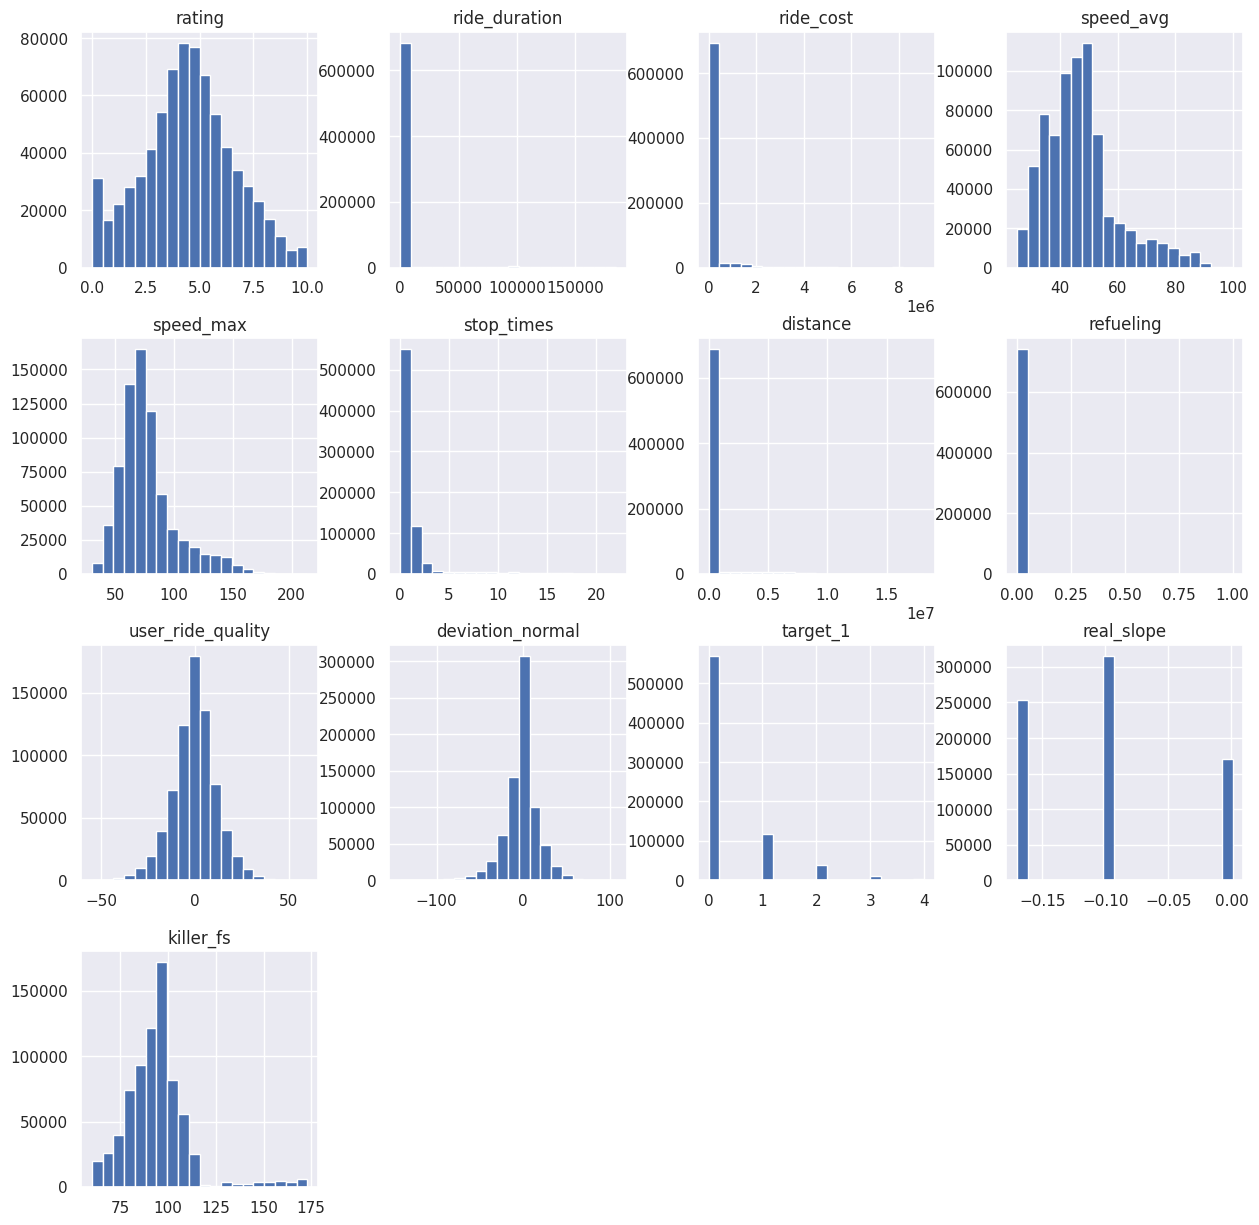

In [37]:

# generate = False


if generate:
    X_blobs, _ = make_blobs(n_samples = generation_config['n_samples'],
                              centers = generation_config['n_clusters'],
                              cluster_std = generation_config['cluster_std'],
                              center_box = generation_config['center_box'],
                              n_features = generation_config['n_features'],
                              random_state = generation_config['random_state'],
                             )
    
    df = pd.DataFrame(X_blobs, columns = cols)
    print('Создали базовый датафрейм')
    df['tmp'] = 1

    df['distance'] -= df['distance'].mean()
    df['distance'] = df['distance'].apply(make_crew)
    df['refueling'] = (df['refueling'] > df['refueling'].max()*0.95)*1
    df['speed_max'] = df['speed_max'] // (df['speed_max'].max()*0.01)
    df['stop_times'] = abs(df['stop_times'])

    
    cycler = cycle(cars_ids)
    df['car_id'] = df['tmp'].progress_apply(lambda x: next(cycler))
    df['ride_id'] =  df['tmp'].progress_apply(hash_f)

    # user_id = get_user_by_car(car_id)
    # df['user_id'] = df['tmp'].apply(rider_hash)
    print('Приклеиваем таргет')
    df = df.merge(car_info[['car_id', 'target_1', 'target_2', 'car_type', 'fuel_type']], on = 'car_id', how = 'left')
    # df['target_1'], df['target_2'] = zip(*df.progress_apply(get_targets, axis=1))
    print('Приклеиваем юзеров')
    df['user_id'] = df.progress_apply(get_user_by_car, axis=1)
     
    
    print('Приклеиваем воркеров')
    worker_uniq_f = lambda x: x.nunique()
    crit_sum_f = lambda x: sum(x >= 8)

    cols = ['car_id', 'worker_id', 'work_type', 'destroy_degree']
    fix_info_gr = fix_info[cols].groupby('car_id', as_index=False).agg(worker_uniq = ('work_type', worker_uniq_f), 
                                                                       crit_sum = ('destroy_degree', crit_sum_f))

    df = df.merge(fix_info_gr, on = 'car_id', how = 'left')
    
    # Target -> speed_max -> rating
    
    # rider_info patterns
    cols = ['user_id','age', 'user_rides', 'user_time_accident']
    df = df.merge(rider_info[cols], on = 'user_id', how = 'left')
    df['user_rides_pattern'] = df.groupby('car_id', as_index=False)['user_rides'].transform('median')['user_rides'].values
    df['user_time_accident_pattern'] = df.groupby('car_id', as_index=False)['user_time_accident'].transform('median')['user_time_accident'].values
    df['age_pattern'] = df.groupby('car_id', as_index=False)['age'].transform('median')['age'].values
    
    
    # TODO использовать фичи юзера !!! pattert_by_user
    # TODO использовать фичи ремонта !!!
    

    start, end = "2020-01-01", "2020-04-02"
    df['ride_date'] = pd.date_range(start, end, periods=N_riders)
    df['hour'] = df['ride_date'].dt.hour
    df['ride_date'] = df['ride_date'].dt.date.values
    
    print('Генерируем базовые признаки')
    
    df['ride_duration'] = abs(df['ride_duration'] - df['ride_duration'].mean()) + np.random.random(size = df.shape[0])*df['ride_duration'].max()*5
    df['ride_duration'] += np.random.choice([0, 1], size = df.shape[0], p = [0.92, 0.08])*np.random.randint(df['ride_duration'].max()*5000*np.random.random(), size = df.shape[0])
    df['rating'], df['speed_avg'], df['speed_max'], df['ride_duration'], df['stop_times'], df['ride_cost'], df['distance'] = zip(*df.progress_apply(generate_features, axis=1))
    
    
    # print('Приклеиваем таргет')
    # df['target_1'], df['target_2'] = zip(*df.progress_apply(get_targets, axis=1))
    df.sort_values(['car_id','ride_date'], inplace=True)
    
    tmp = df[['car_id', 'target_2']].drop_duplicates('car_id')
    tmp['deviation_normal'], tmp['killer_fs'] =  zip(*tmp['target_2'].progress_apply(get_ts_by_target))
    
    
    print('Закладываем влияние паттерна водителей')
    df['speed_max'] = df.progress_apply(pattern_by_user, axis=1) # Вклад юзера
    df['ride_cost'] = df.progress_apply(coast_pattern_by_user, axis=1) # Вклад юзера
    
    # отклонения TO от нормы - оценивает общее техническое состояние машины на основе разных датчиков
    print('Генерируем временные признаки')
    df['deviation_normal'] = tmp.explode('deviation_normal')['deviation_normal'].values
    df['killer_fs'] = tmp.explode('deviation_normal')['killer_fs'].values
    df['deviation_normal'] = df.progress_apply(deviation_normal_pattern, axis=1) # Вклад юзера
    
    f = lambda x: target_dict.get(x, x)['mu']
    df['real_slope'] = df['target_2'].progress_apply(f)
    
    stable_dataset = random_walks(n_ts=len(cars_ids), sz=int(30*num_months*2), d=1, mu=[-1/90], std=5/4)

    # качество поездки - отражает манеру возждения водителя.  
    df['user_ride_quality'] = stable_dataset.reshape(-1, 1) 
    df['user_ride_quality'] = df.progress_apply(add_pattern_by_target, axis=1)
    df['rating'] = df.progress_apply(rating_pattern_by_target, axis=1)
    
    df['stop_times'] = df['stop_times'].astype(int)
    df['ride_cost'] = abs(df['ride_cost'])

    cols = ['tmp', 'year', 'month', 'day', 'hour', 'car_type', 'fuel_type', 'worker_uniq', 'crit_sum']
    
    df.drop(cols, axis=1, inplace=True, errors='ignore')
    df['rating'] = df['rating'].round(2)
    df['deviation_normal'] = df['deviation_normal'].astype('float').round(3)
    df['ride_cost'] = df['ride_cost'].astype(int)
     
        
    
    cols = ['user_id', 'car_id', 'ride_id', 'ride_date', 'rating',
            'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling',
            'user_ride_quality', 'deviation_normal',
            
            # 'nan_user_ride_quality',
            'target_1', 'target_2', 'real_slope', 'killer_fs']

    rides_info = df[cols]
    
    drop_fs = ['target_1', 'target_2', 'real_slope', 'killer_fs', 'car_rating', 'user_time_accident']
    
    
    rides_info.drop(drop_fs, axis=1, errors = 'ignore').to_csv('../data/rides_info.csv', index=False)
    rides_info.to_csv('../data/tmp_rides_info.csv', index=False)
    rides_info.hist(figsize = (15, 15), bins=20)
    print(rides_info.shape)
    rides_info.describe()

else:
    
    rides_info = pd.read_csv('../data/tmp_rides_info.csv')
    

In [38]:
# rides_info[rides_info['ride_duration'] < 600]['ride_duration'].hist(bins=40)

In [39]:
# rides_info.info()
# pd.read_csv('../data/rides_info.csv')

# df[['car_id', 'target_2']]#.#drop_duplicates('car_id')
# df['car_id'].nunique()

# worker_uniq_f = lambda x: x.nunique()
# crit_sum_f = lambda x: sum(x >= 8)

# cols = ['car_id', 'worker_id', 'work_type', 'destroy_degree']
# fix_info_gr = fix_info[cols].groupby('car_id',
#                                      as_index=False).agg(worker_uniq = ('work_type', worker_uniq_f), 
#                                                          crit_sum = ('destroy_degree', crit_sum_f))
# fix_info_gr.hist(bins=20);

In [40]:
# df['ride_date'].unique()

In [41]:
# plt.figure(figsize=(20, 10))
# sns.lineplot(data = rides_info, x = 'ride_date', y = 'deviation_normal', hue = 'car_id', style='target_2', legend=False); 
# rides_info.head(1)

In [42]:
# df.columns


user_id      car_id ride_id   ride_date  rating  ride_duration  \
424  A13448969y  A-1005804b     g1D  2020-01-01    7.64             31   

     ride_cost  speed_avg  speed_max  stop_times     distance  refueling  \
424        243         44       75.0           2  1209.345763          0   

     user_ride_quality  deviation_normal  target_1     target_2  real_slope  \
424           0.979531             2.373         1  another_bug        -0.0   

     killer_fs  
424         81

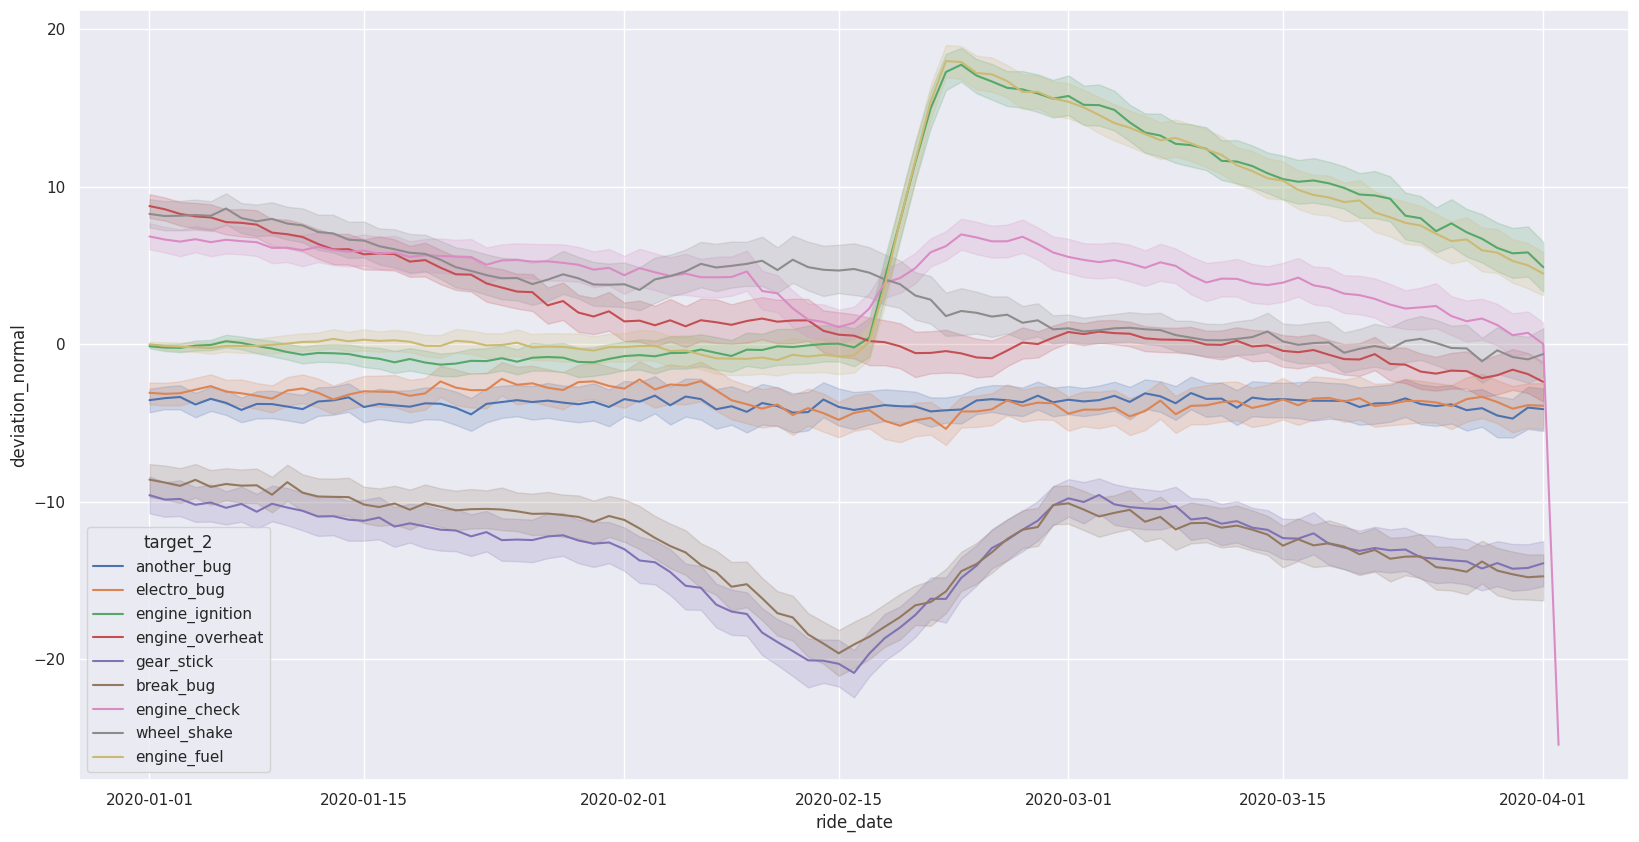

In [43]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rides_info, x = 'ride_date', y = 'deviation_normal', hue = 'target_2', legend=True); 
rides_info.head(1)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
424  A13448969y  A-1005804b     g1D  2020-01-01    7.64             31   

     ride_cost  speed_avg  speed_max  stop_times     distance  refueling  \
424        243         44       75.0           2  1209.345763          0   

     user_ride_quality  deviation_normal  target_1     target_2  real_slope  \
424           0.979531             2.373         1  another_bug        -0.0   

     killer_fs  
424         81

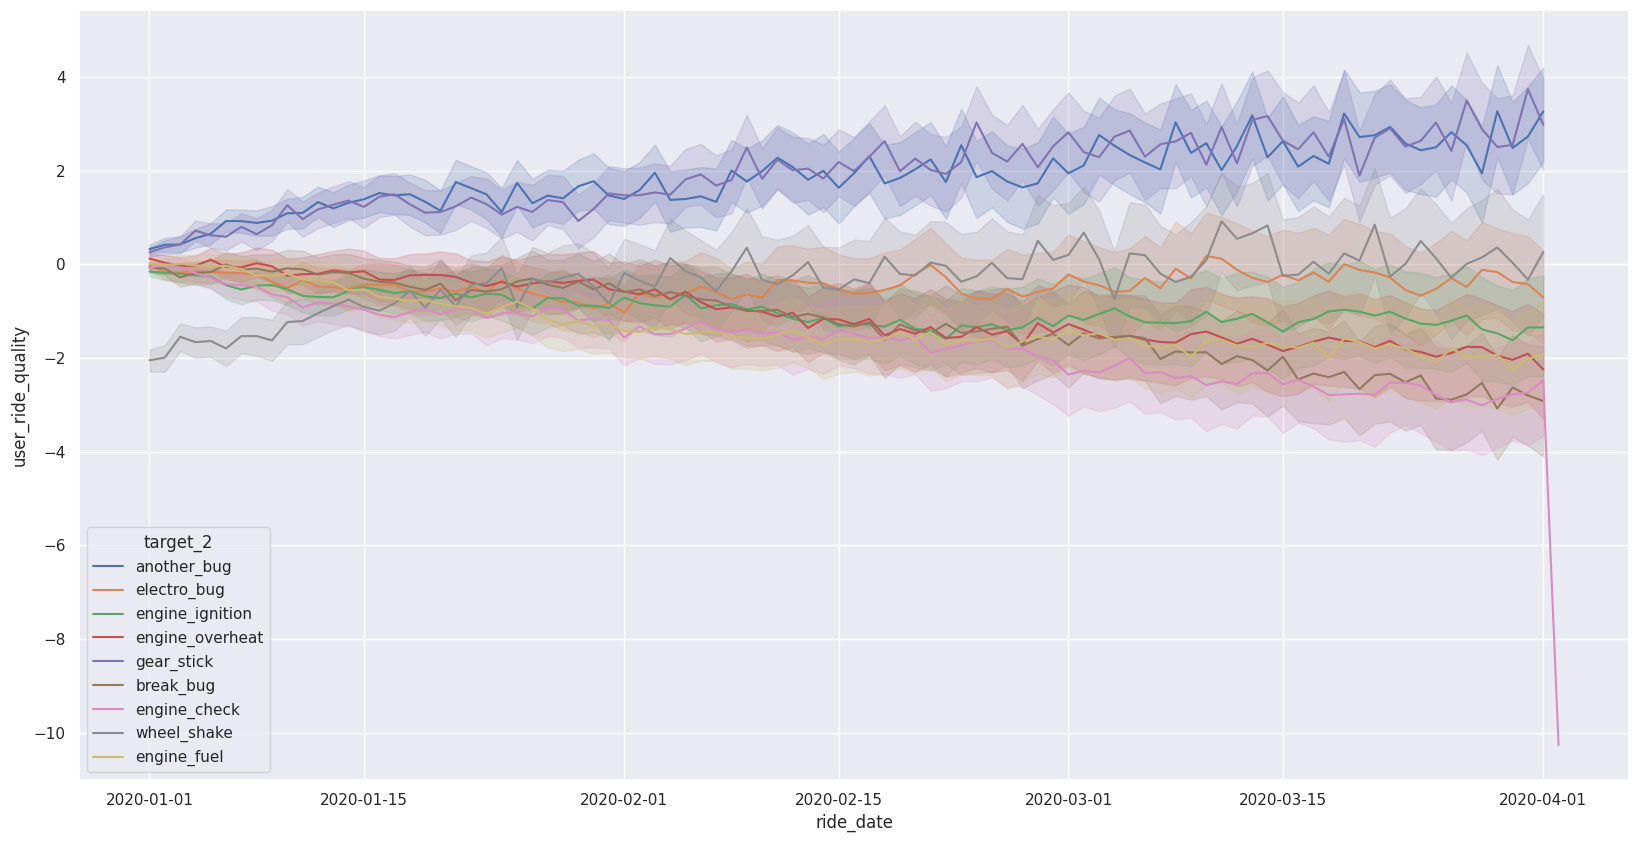

In [44]:
plt.figure(figsize=(20, 10))
sns.lineplot(data = rides_info, x = 'ride_date', y = 'user_ride_quality', hue = 'target_2', legend=True); 
rides_info.head(1)


# plt.figure(figsize=(20, 10))
# sns.lineplot(data = rides_info[rides_info['user_id'].isin(np.random.choice(rides_info['user_id'].unique(), size=100))], x = 'ride_date', y = 'user_ride_quality', hue = 'car_id', legend=False); 
# rides_info.head(1)

In [45]:
# sns.displot(data=rides_info, x='deviation_normal', aspect=3)

In [46]:
# sns.displot(data=rides_info, x='deviation_normal', hue='target_2', aspect=3);

In [47]:
# sns.displot(data=rides_info, x='deviation_normal', y='ride_date',
#             aspect=3, hue='target_2');

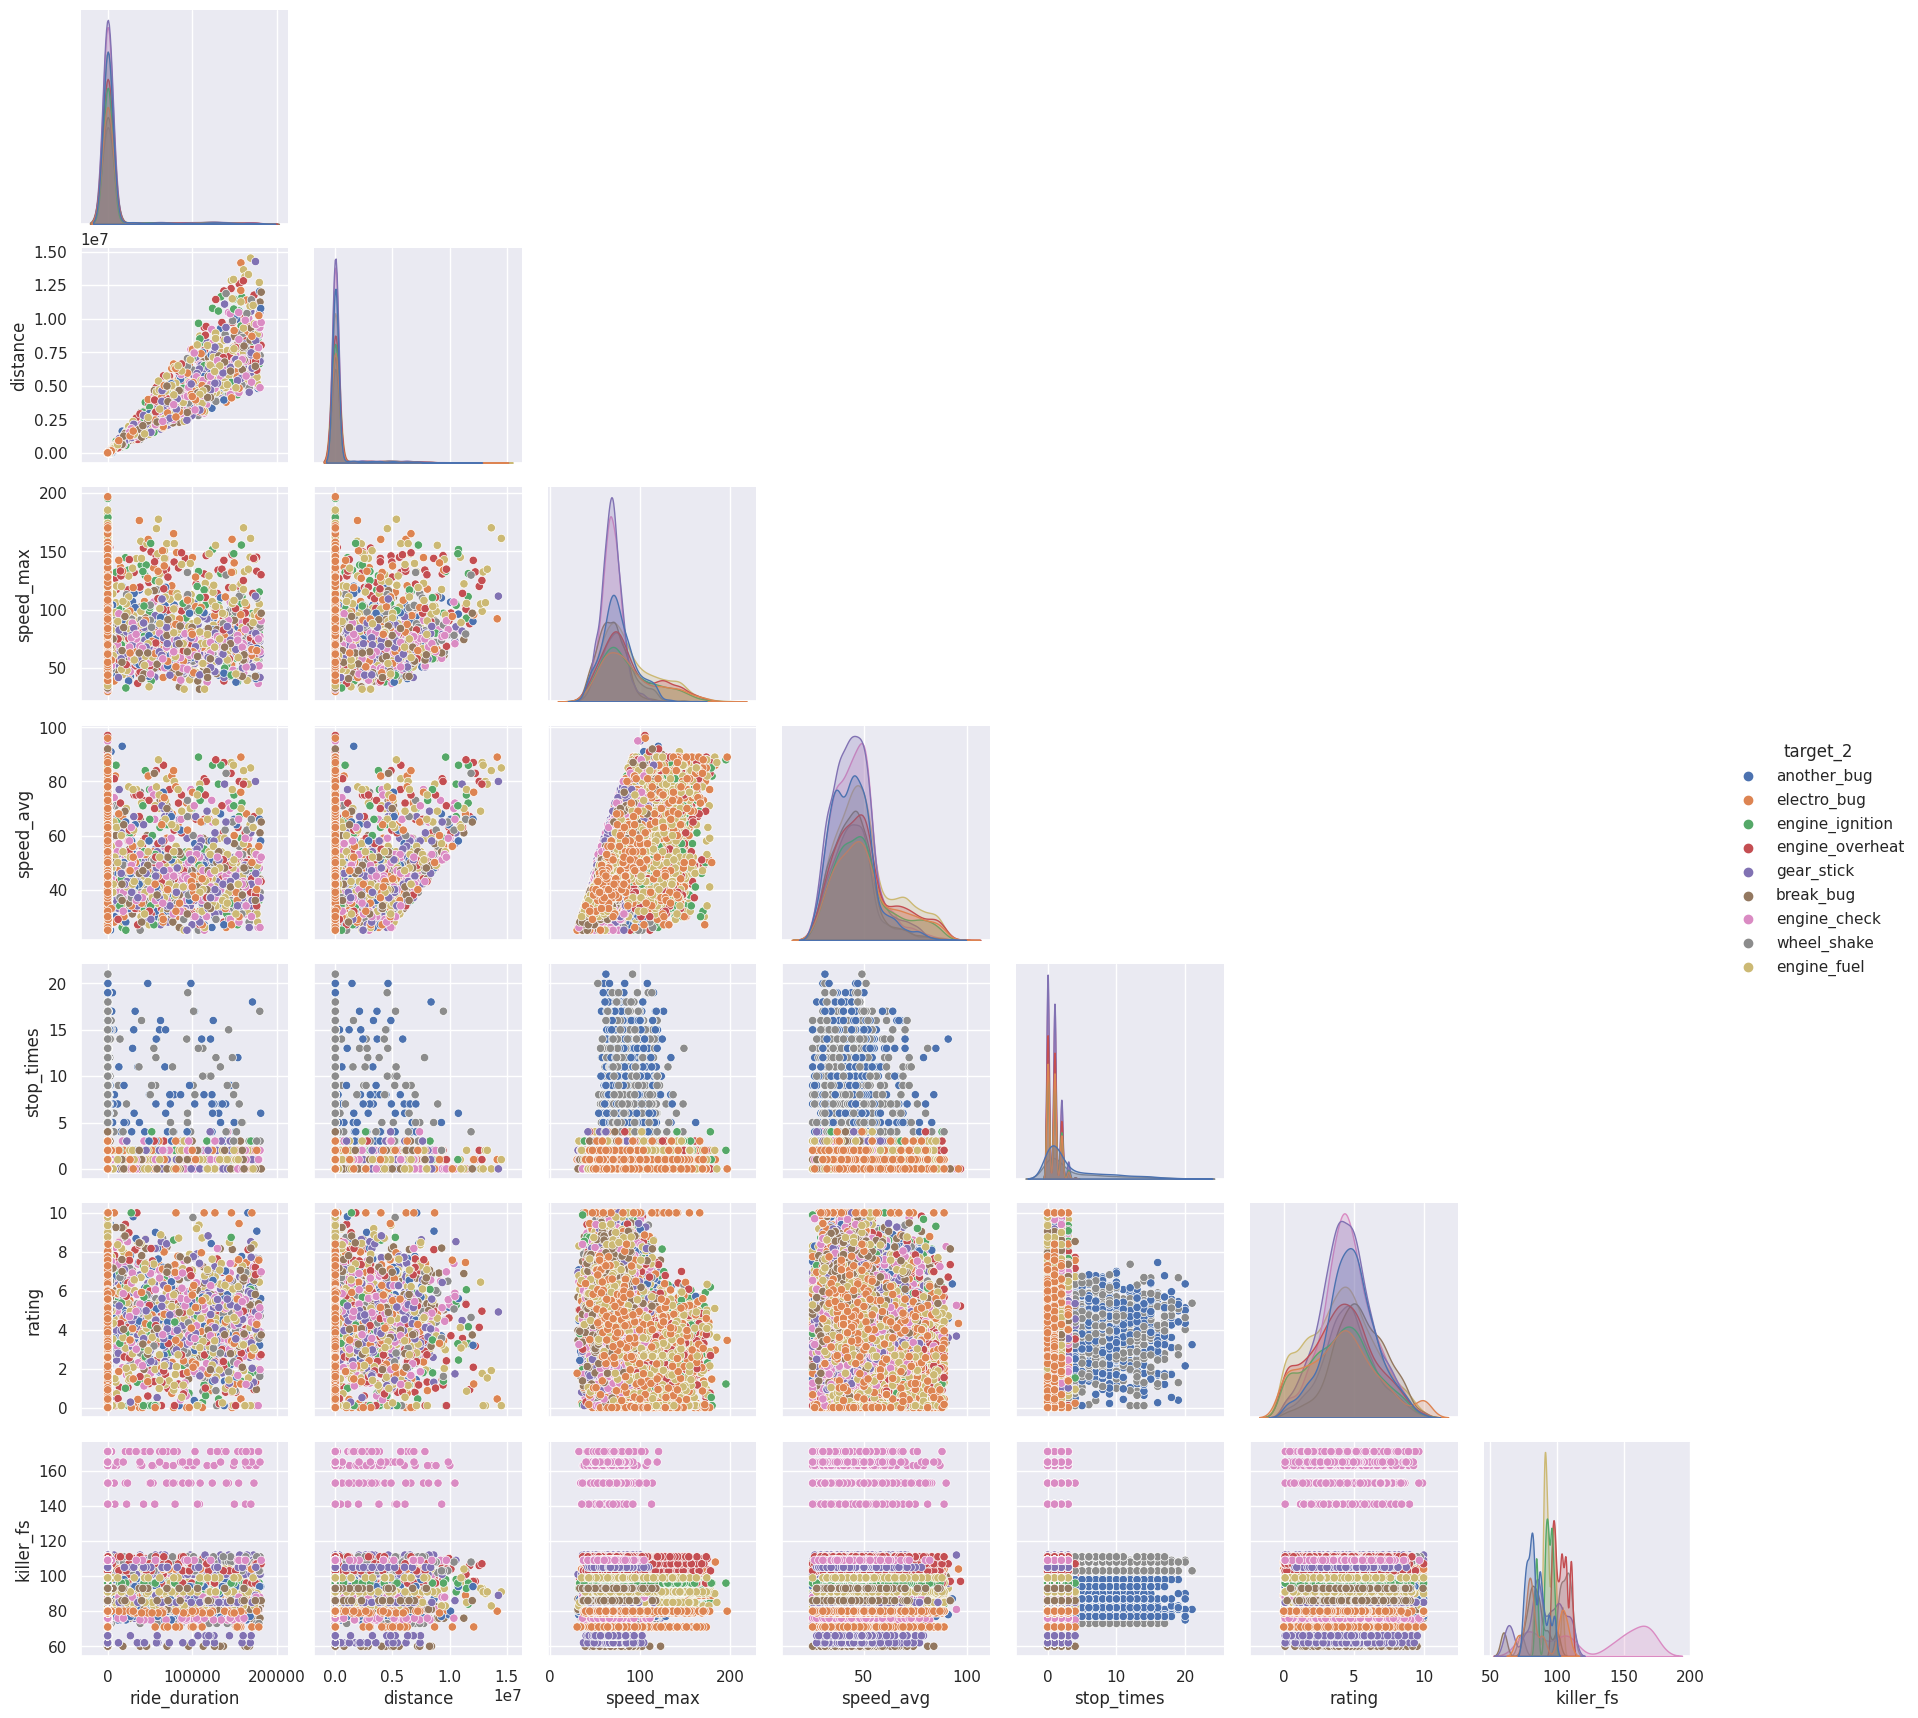

In [48]:
cols = ['ride_duration', 'distance', 'speed_max', 'speed_avg', 'target_2', 'stop_times', 'rating', 'killer_fs']
ids_car = rides_info['car_id'].unique()[:100]
tmp = rides_info[rides_info['car_id'].isin(ids_car)]
sns.pairplot(data = tmp[cols], hue = 'target_2', corner=True);

# Reduce Quality

0

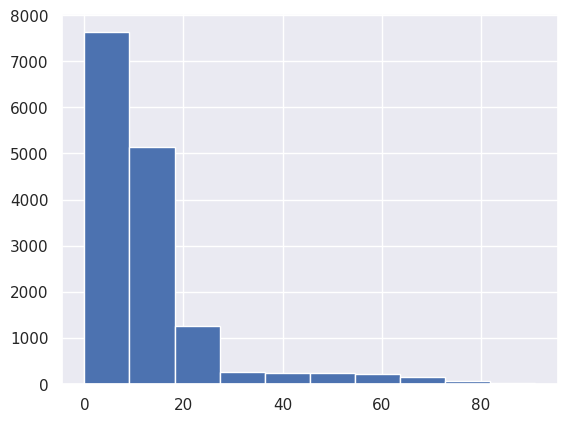

In [247]:
    
def make_nones(x):
    num = int(x.first_ride_date.split('-')[-1])
    
    if np.random.random() > 0.26 and x.user_time_accident > 25:
        return None

    if num % 5 == 0 and np.random.random() > 0.25 and x.user_time_accident > 65:
        return None
        
    return x.user_time_accident


        
rider_info = pd.read_csv('../data/tmp_driver_info.csv')
rider_info['user_time_accident'].hist()
rider_info['user_time_accident'].isnull().sum()

907

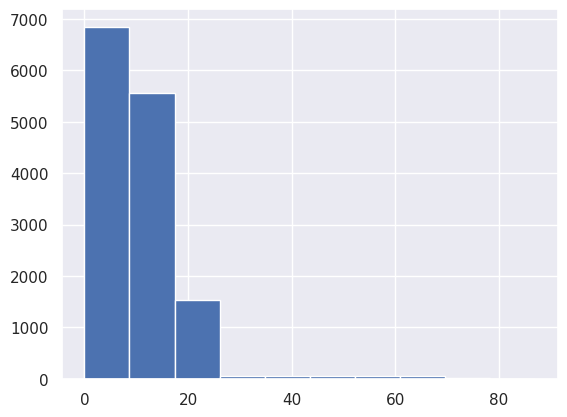

In [248]:
rider_info['user_time_accident'] = rider_info.apply(make_nones, axis=1)
rider_info.drop('eng_check', axis=1, errors = 'ignore').to_csv('../data/driver_info.csv', index=False)
rider_info['user_time_accident'].hist()
rider_info['user_time_accident'].isnull().sum()

In [249]:
# rides_info

# Добавляем сгенерированные фичи и далее от них генерируем таргет

In [250]:
# Добавляем признаки из информации про поездки

q_right = lambda x : sum(x > 120)/len(x)
f_low_r = lambda x : sum(x < 2.0)

# rides_info['real_slope'] = abs(rides_info['real_slope'])
rides_info_ = rides_info.merge(rider_info, on = 'user_id', how = 'left')


rides_info_['nan_user_ride_quality'] = rides_info_['user_ride_quality'].isnull()*1
rides_info_['high_user_ride_quality'] = rides_info_['user_ride_quality'].values > 10
rides_info_['nan_speed_max'] = rides_info_['speed_max'].isnull()*1


rides_info_gr = rides_info_.groupby('car_id', as_index=False).agg(
    ride_duration_sum = ('ride_duration', 'sum'),
    ride_distance_sum = ('distance', 'sum'),
    speed_avg_mean = ('speed_avg', 'mean'),
    speed_max_mean = ('speed_max', 'mean'),
    speed_max_q = ('speed_max', q_right),
    speed_max_max = ('speed_max', 'max'),
    
    mean_ride_cost = ('ride_cost', 'mean'),
    nan_sum = ('nan_user_ride_quality', 'max'),
    high_sum = ('high_user_ride_quality', 'max'),
    
    user_time_accident_max = ('user_time_accident', 'max'),
    user_time_accident_mean = ('user_time_accident', 'mean'),
    user_rating_min = ('user_rating', 'min'),
    user_rides_min = ('user_rides', 'min'),
    nan_speed_max = ('nan_speed_max', 'sum'),

    
    crit_low_r = ('rating', f_low_r),
    killer_fs = ('killer_fs', 'max'),
    # real_slope = ('real_slope', 'max'),
)


# Groupby + Transform

In [251]:
# (rides_info['real_slope'].value_counts().index - rides_info['real_slope'].min()) /  rides_info['real_slope'].max()
# rides_info_gr['real_slope'].value_counts(dropna=False)

In [252]:
fix_info['worker_experience'] = fix_info.groupby('worker_id')['car_id'].transform('count')

car_id worker_id         fix_date     work_type  destroy_degree  \
0  C16209094m        ZT   2020-6-20 2:14     reparking             1.0   
1  G-1559355l        PS   2020-2-9 20:25        repair             3.5   
2  v-1144396k        EM    2019-8-24 7:1     reparking             1.0   
3  P14360916q        XO   2019-8-10 9:29     reparking            10.0   
4  b13819346G        OH  2020-11-12 5:22  refuel_check             1.0   

   work_duration  worker_experience  
0             20                274  
1              1                267  
2             27                235  
3             62                268  
4             22                288

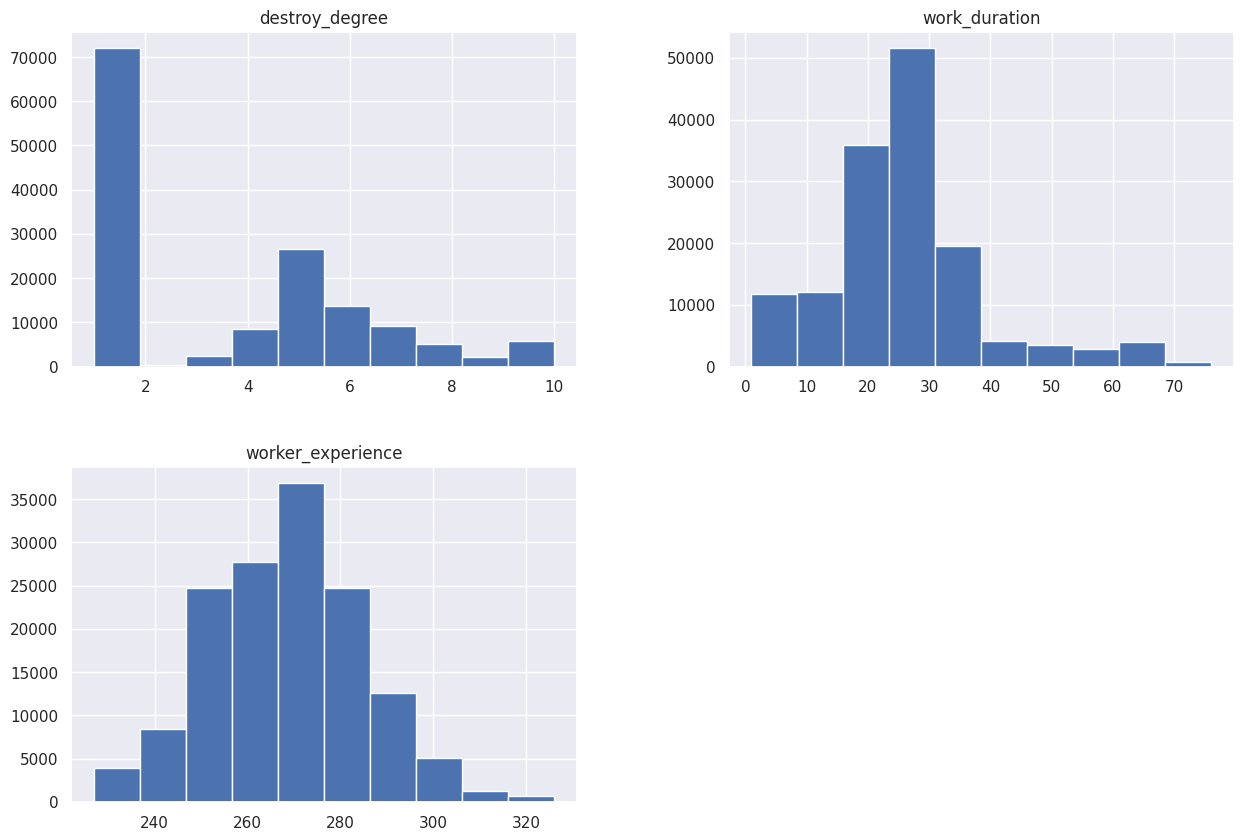

In [253]:
fix_info.hist(figsize = (15, 10))
fix_info.head()

# Fix_info + Pivot Table

In [254]:
# fix_info

fix_info_pivot = fix_info.pivot_table(index = 'car_id', columns = ['work_type'], values = ['destroy_degree'], aggfunc = ['mean', 'count'])#.columns
fix_info_pivot.columns = [f'{i[2]}_{i[0]}' for i in fix_info_pivot.columns]
fix_info_pivot.reset_index(inplace=True)
fix_info_pivot.sample(10)


car_id  refuel_reparking_mean  refuel_mean  reparking_mean  \
2797  i-1075849x                    NaN          1.0        1.266667   
1434  R57021988p                    NaN          1.0        1.000000   
3948  w11749649R                    NaN          1.0        1.000000   
3405  p-7687636X                    NaN          1.0        1.000000   
4005  x-2262215b                    NaN          1.0        1.470588   
1429  R21899595e                    NaN          NaN        1.615385   
186   C-2199252t                    NaN          1.0        1.000000   
1852  W22443120z                    NaN          1.0        2.307692   
1362  Q85934212e                    NaN          1.0        2.600000   
1577  T-4589077l                    NaN          1.0        1.727273   

      repair_mean  refuel_check_mean  oil_change_mean  refuel_reparking_count  \
2797     4.675000               1.00              NaN                       0   
1434     6.385714               1.00              NaN                       0   
3948     5.920000               1.00              NaN                       0   
3405     6.621053               1.00              NaN                       0   
4005     6.471429               1.00              NaN                       0   
1429     4.927778               1.00              NaN                       0   
186      6.253333               1.00              NaN                       0   
1852     5.916667               1.00              NaN                       0   
1362     5.984615               2.75              NaN                       0   
1577     4.850000               1.00              NaN                       0   

      refuel_count  reparking_count  repair_count  refuel_check_count  \
2797             1               15            16                   2   
1434             1               17            14                   2   
3948             1               15            15                   3   
3405             3                8            19                   4   
4005             2               17            14                   2   
1429             0               13            18                   3   
186              2               13            15                   4   
1852             2               13            18                   1   
1362             2               15            13                   4   
1577             3               11            18                   2   

      oil_change_count  
2797                 0  
1434                 0  
3948                 0  
3405                 0  
4005                 0  
1429                 0  
186                  0  
1852                 0  
1362                 0  
1577                 0

# Fix_info + Groupby

car_id  worker_count  destroy_degree_max  destroy_degree_sum  \
172   C-1837253z            35                10.0               111.6   
1908  X-8833199o            35                 5.0               112.2   
1752  V18899000d            34                 5.0                96.0   
2494  e-3698740a            34                10.0               147.2   
2455  d81348551m            35                10.0               131.0   

      work_duration_mean  work_duration_max  work_type_nuniq  \
172            28.942857                 64                4   
1908           23.885714                 55                4   
1752           23.617647                 72                4   
2494           32.882353                 71                4   
2455           25.285714                 66                4   

                                         work_type_moda  \
172                                           reparking   
1908                                             repair   
1752  ['reparking', 'repair']
Categories (6, object)...   
2494                                             repair   
2455                                             repair   

     work_type_seconde_moda  work_type_crit_perc_q  work_type_crit_q  \
172                  refuel               0.114286                 4   
1908                 refuel               0.000000                 0   
1752             oil_change               0.000000                 0   
2494                 refuel               0.264706                 8   
2455                 refuel               0.114286                 3   

      worker_experience_mean  worker_low_exp  
172               270.885714               0  
1908              267.000000               0  
1752              267.147059               0  
2494              270.323529               0  
2455              267.714286               0

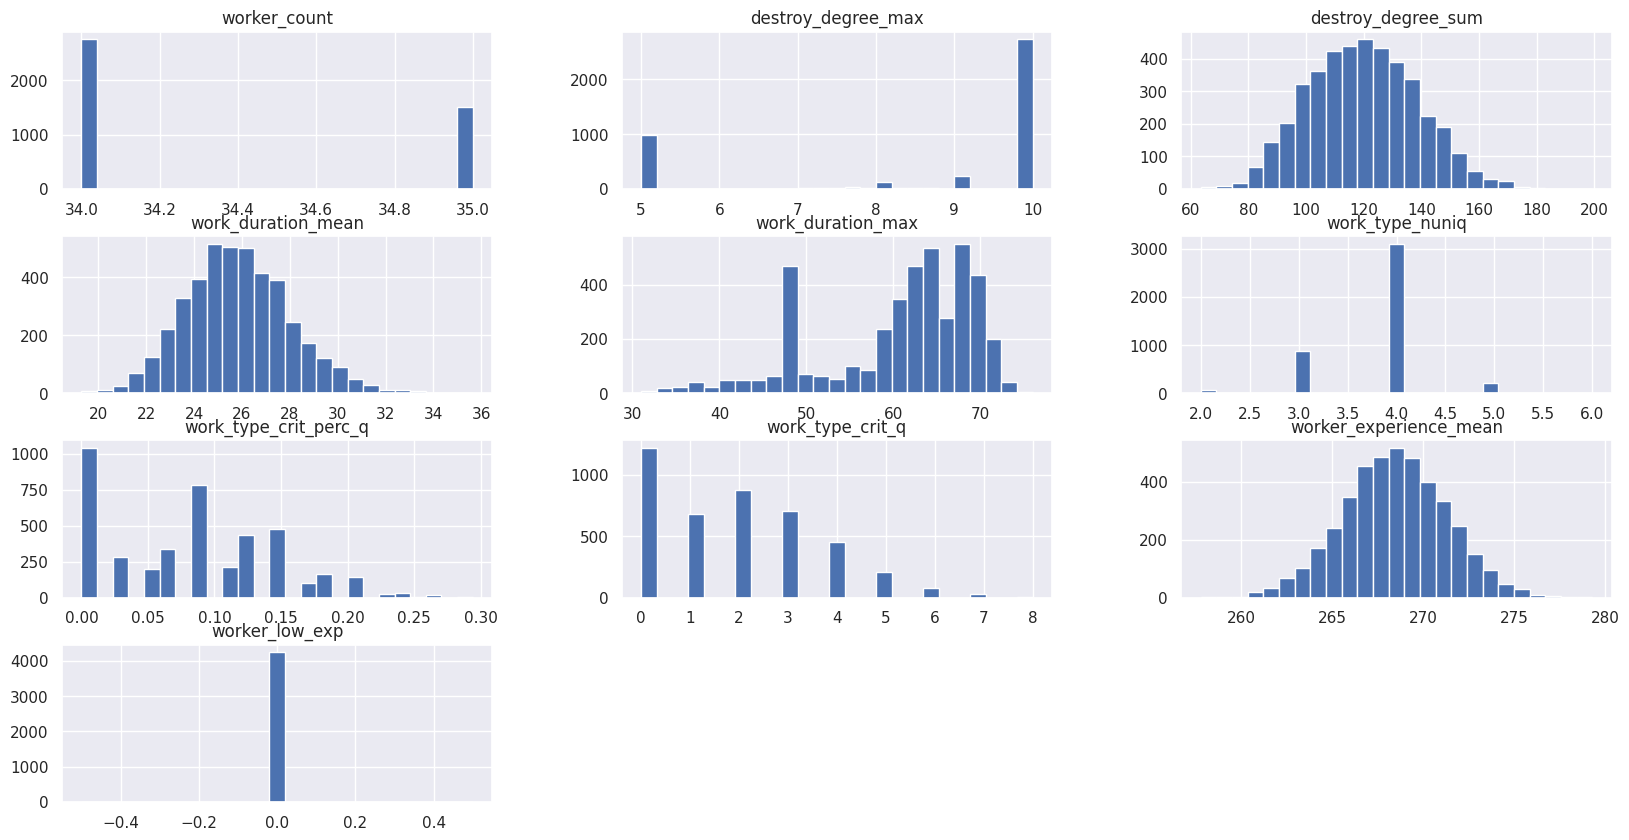

In [255]:
# Добавляем признаки из информации про ремонт

f_nuniq = lambda x : len(np.unique(x))
f_crit_perc_q = lambda x : sum(x >= 7.5)/len(x)
f_crit_q = lambda x : sum(x > 8.0)

avg_exp = fix_info['worker_experience'].median()
f_low_exp = lambda x: sum(x <= avg_exp*0.5)

# second_mode = lambda x: print( [ i for i in x if i not in [pd.Series.mode(x).values[0]] ] ) 
second_mode = lambda x: np.unique([ i for i in x if i not in [pd.Series.mode(x).values[0]] ])[0]

fix_info_gr = fix_info.groupby('car_id', as_index=False).agg(
    worker_count = ('worker_id', 'count'),
    destroy_degree_max = ('destroy_degree', 'max'),
    destroy_degree_sum = ('destroy_degree', 'sum'),
    work_duration_mean = ('work_duration', 'mean'),
    work_duration_max = ('work_duration', 'max'),
    work_type_nuniq = ('work_type', f_nuniq),
    
    work_type_moda = ('work_type', pd.Series.mode ),
    work_type_seconde_moda = ('work_type', second_mode),
    
    work_type_crit_perc_q = ('destroy_degree', f_crit_perc_q),
    work_type_crit_q = ('destroy_degree', f_crit_q),
    worker_experience_mean = ('worker_experience', 'mean'),
    worker_low_exp = ('worker_experience', f_low_exp),
)
fix_info_gr.hist(figsize = (20, 10), bins=25)
fix_info_gr.sample(5)

# Tsfresh + time series

In [256]:
!pip install tsfresh -q

In [257]:
# Добавляем признаки временные из информации про поездки с помощью TSfresh

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
import tsfresh

In [258]:
from tsfresh.feature_extraction import settings

settings_efficient = {}

settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
# settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())
# settings_efficient.update(settings.EfficientFCParameters())

settings_efficient

{'linear_trend_timewise': [{'attr': 'pvalue'}, {'attr': 'rvalue'}, {'attr': 'intercept'}, {'attr': 'slope'}, {'attr': 'stderr'}], 'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None, 'skewness': None, 'kurtosis': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None}

In [259]:
# rides_info.car_id.value_counts() #.head(3)

rides_info#['deviation_normal'].isnull().sum()

user_id      car_id ride_id   ride_date  rating  ride_duration  \
424     A13448969y  A-1005804b     g1D  2020-01-01    7.64             31   
4674    r21786197M  A-1005804b     w1D  2020-01-01    4.37         170983   
8924    t61081975Z  A-1005804b     U1v  2020-01-02    5.34         145059   
13174   G13604635n  A-1005804b     E1u  2020-01-02    7.43             41   
17424   U38214398i  A-1005804b     A1b  2020-01-03    6.57             42   
...            ...         ...     ...         ...     ...            ...   
720815  G22481388c  z90470541K     R1z  2020-03-30    1.30             43   
725065  f11135170E  z90470541K     L1E  2020-03-31    2.57             63   
729315  o20719723X  z90470541K     c1L  2020-03-31    0.16             31   
733565  T12882579G  z90470541K     C1Z  2020-04-01    3.13          15195   
737815  R32085397g  z90470541K     V1d  2020-04-01    7.75             42   

        ride_cost  speed_avg   speed_max  stop_times      distance  refueling  \
424           243         44   75.000000           2  1.209346e+03          0   
4674      1590138         48   71.057242          18  8.375023e+06          0   
8924      1160466         48   80.000000           1  7.103321e+06          0   
13174         364         27  107.000000           1  9.334576e+02          0   
17424         456         43   62.000000           2  1.369904e+03          0   
...           ...        ...         ...         ...           ...        ...   
720815        598         50   60.000000           1  1.308828e+03          0   
725065        876         47   58.000000           0  2.178765e+03          0   
729315        429         26   48.000000           1  6.448566e+02          0   
733565     212725         54   82.000000           1  8.354873e+05          0   
737815        581         30   48.000000           1  1.194999e+03          0   

        user_ride_quality  deviation_normal  target_1      target_2  \
424              0.979531             2.373         1   another_bug   
4674             2.304357             5.127         1   another_bug   
8924             1.220040             0.874         1   another_bug   
13174            2.046063             2.177         1   another_bug   
17424            1.525146             1.030         1   another_bug   
...                   ...               ...       ...           ...   
720815          33.071124           -13.625         0  engine_check   
725065          32.325063           -15.554         0  engine_check   
729315          32.052018           -17.897         0  engine_check   
733565          32.427570           -17.812         0  engine_check   
737815          33.277668           -19.199         0  engine_check   

        real_slope  killer_fs  
424           -0.0         81  
4674          -0.0         81  
8924          -0.0         81  
13174         -0.0         81  
17424         -0.0         81  
...            ...        ...  
720815        -0.1         83  
725065        -0.1         83  
729315        -0.1         83  
733565        -0.1         83  
737815        -0.1         83  

[739500 rows x 18 columns]

In [260]:
settings = settings_efficient

# train_df.fillna(0, inplace=True)
res_train_df = None
# res_test_df = None

numeric_cols = ['deviation_normal', 'user_ride_quality']
vr = VarianceThreshold(0)
for num, num_col in enumerate(numeric_cols):
    now = datetime.now()
    print(num, 'col', num_col)
    
#     settings = full_settings_filtered[num_col]
    
    Distributor = MultiprocessingDistributor(n_workers=4,
                                             disable_progressbar=False,
                                             progressbar_title="Feature Extraction")

    X = extract_features(rides_info[["car_id", "ride_date", num_col]].fillna(0), 
#                                   y,
                                  column_id='car_id',
                                  column_sort='ride_date',
                                  n_jobs=1,
#                                   chunksize=5,
                                  default_fc_parameters=settings_efficient#settings,
#                                   fdr_level = 0.01,
#                                   distributor = Distributor
                        )
    
    X = pd.DataFrame(vr.fit_transform(X), columns=X.columns[vr.get_support()])
    print('прошло времени после генерации', datetime.now() - now)
        
    if res_train_df is None:
        res_train_df = X
#         res_train_df["target"] = rides_info['target_2']
        res_train_df["car_id"] = rides_info['car_id'].unique()
    else:
        # X = reduce_mem_usage(X)
        res_train_df = pd.concat([res_train_df, X], axis=1)
#         res_train_df.to_csv("./../tmp_data/del_full_train_tsfresh.csv", index=False)        
        print('прошло времени до сохраниения', datetime.now() - now)


0 col deviation_normal


Feature Extraction: 100%|██████████| 4250/4250 [00:03<00:00, 1286.03it/s]


прошло времени после генерации 0:00:03.742378
1 col user_ride_quality


Feature Extraction: 100%|██████████| 4250/4250 [00:03<00:00, 1268.60it/s]

прошло времени после генерации 0:00:03.791907
прошло времени до сохраниения 0:00:03.792452


In [261]:
# fix_info_pivot

# Собираем все таблицы в одну группу

In [262]:
print(car_info['car_id'].nunique())
car_info_fs = pd.merge(car_info, rides_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])

car_info_fs = pd.merge(car_info_fs, fix_info_pivot, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])

car_info_fs = pd.merge(car_info_fs, fix_info_gr, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape[0])


car_info_fs = pd.merge(car_info_fs, res_train_df, on = 'car_id', how = 'left')
print(car_info_fs['car_id'].nunique(), car_info_fs.shape)

car_info_fs.head()

4250
4250 4250
4250 4250
4250 4250
4250 (4250, 74)


car_type fuel_type  car_rating  year_to_start  riders      car_id  \
0  economy    petrol        24.4           2015   13740  C16209094m   
1  economy    petrol        22.4           2015   14823  G-1559355l   
2  economy    petrol        22.0           2013   16821  v-1144396k   
3  economy    petrol        19.3           2017   56910  P14360916q   
4  economy    petrol        14.7           2014    9255  b13819346G   

          model  target_1         target_2  year_to_work  ...  \
0    VW Polo VI         1  engine_overheat          2019  ...   
1    VW Polo VI         1      electro_bug          2021  ...   
2    VW Polo VI         0        break_bug          2016  ...   
3  Smart ForTwo         0      another_bug          2016  ...   
4   Skoda Rapid         0       gear_stick          2015  ...   

   user_ride_quality__mean  user_ride_quality__standard_deviation  \
0                10.393611                              12.668658   
1                 3.179968                               5.018077   
2                -6.986245                               9.004079   
3                13.019274                               4.681020   
4                -2.767296                               7.450618   

   user_ride_quality__variance  user_ride_quality__root_mean_square  \
0                   160.494887                            16.386642   
1                    25.181098                             5.940816   
2                    81.073444                            11.396537   
3                    21.911947                            13.835224   
4                    55.511713                             7.947933   

   user_ride_quality__maximum  user_ride_quality__absolute_maximum  \
0                   37.125580                            37.125580   
1                   16.282095                            16.282095   
2                    6.908779                            28.666085   
3                   20.841706                            20.841706   
4                   14.901547                            15.523808   

   user_ride_quality__minimum  user_ride_quality__skewness  \
0                   -8.785830                     0.393184   
1                   -4.797755                     0.485854   
2                  -28.666085                    -0.915174   
3                    0.799420                    -0.731424   
4                  -15.523808                     0.506842   

   user_ride_quality__kurtosis  \
0                    -0.857618   
1                    -0.516331   
2                     0.020181   
3                    -0.343648   
4                    -0.811548   

   user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints  
0                                           0.000000                          
1                                           0.000000                          
2                                           0.000000                          
3                                           0.000000                          
4                                           0.051724                          

[5 rows x 74 columns]

In [263]:
# car_info_fs['work_duration_mean'].hist()

# Отнормируем фичи, чтоб легче было слепить из них таргет

In [264]:
!pip install sklearn_pandas >> None

In [265]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

to_scale_fs = ['car_rating', 'year_to_start', 'riders', 'ride_duration_sum', 'speed_avg_mean',
               'ride_distance_sum', 
               'speed_max_mean', 'speed_max_q', 'speed_max_max', 'crit_low_r', 'worker_count',
               'destroy_degree_max', 'destroy_degree_sum', 'work_duration_mean', 'work_duration_max',
               'work_type_nuniq', 'work_type_crit_perc_q', 'work_type_crit_q', 'worker_experience_mean', 
               
               
               'user_time_accident_max', 'user_rating_min', 'user_rides_min',
               
               # 'real_slope',
               'killer_fs',
               
               # 'deviation_normal__linear_trend__attr_"slope"', 
               'repair_count', 'refuel_check_count', 'repair_mean'
              ]

not_to_scale_fs = [c for c in car_info_fs.columns if c not in to_scale_fs]

mapper = DataFrameMapper([(to_scale_fs, MinMaxScaler())])
scaled_features = mapper.fit_transform(car_info_fs.copy(), 4)
car_info_fs_ = pd.DataFrame(scaled_features,
                            index = car_info_fs.index,
                            columns = to_scale_fs)

car_info_fs_ = pd.concat([car_info_fs_, car_info_fs[not_to_scale_fs]], axis=1)

print('car_info_fs_', car_info_fs_.shape)
print('car_info_fs', car_info_fs.shape)
car_info_fs_.sample(5)

car_info_fs_ (4250, 74)
car_info_fs (4250, 74)


car_rating  year_to_start    riders  ride_duration_sum  speed_avg_mean  \
3100    0.620948       0.500000  0.075166           0.272645        0.256757   
3882    0.381546       0.666667  0.439441           0.301862        0.555055   
1218    0.396509       0.666667  0.304548           0.416041        0.283784   
89      0.446384       0.666667  0.285300           0.401235        0.721221   
1891    0.481297       0.000000  0.889784           0.480737        0.236236   

      ride_distance_sum  speed_max_mean  speed_max_q  speed_max_max  \
3100           0.224307        0.105470     0.000000       0.209936   
3882           0.310511        0.679803     0.531915       0.500238   
1218           0.326044        0.353831     0.042553       0.474725   
89             0.477779        0.826268     0.659574       0.672242   
1891           0.453206        0.150408     0.000000       0.167520   

      crit_low_r  ...  user_ride_quality__mean  \
3100    0.096154  ...                -6.684495   
3882    0.750000  ...                 5.428040   
1218    0.307692  ...                -5.232610   
89      0.807692  ...               -16.401768   
1891    0.019231  ...                 5.029221   

      user_ride_quality__standard_deviation  user_ride_quality__variance  \
3100                               8.203190                    67.292325   
3882                               3.098620                     9.601445   
1218                               8.134442                    66.169141   
89                                 8.665019                    75.082555   
1891                               5.297139                    28.059687   

      user_ride_quality__root_mean_square  user_ride_quality__maximum  \
3100                            10.581815                   10.261197   
3882                             6.250205                   12.760065   
1218                             9.672091                   15.384334   
89                              18.549948                   -0.385464   
1891                             7.304297                   16.993747   

      user_ride_quality__absolute_maximum  user_ride_quality__minimum  \
3100                            21.215230                  -21.215230   
3882                            12.760065                   -1.025376   
1218                            22.099073                  -22.099073   
89                              32.648544                  -32.648544   
1891                            16.993747                   -5.782990   

      user_ride_quality__skewness  user_ride_quality__kurtosis  \
3100                     0.207954                    -1.198844   
3882                     0.409849                    -0.638372   
1218                     0.028558                    -0.390723   
89                      -0.537474                    -0.962328   
1891                     0.292259                    -0.800019   

      user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints  
3100                                                0.0                          
3882                                                0.0                          
1218                                                0.0                          
89                                                  0.0                          
1891                                                0.0                          

[5 rows x 74 columns]

In [266]:
# len([col for col in car_info_fs_.columns if col in car_info_fs.columns])
car_info_fs_.shape

(4250, 74)

In [267]:
# car_info_fs_.columns[car_info_fs_.columns.duplicated()]

In [268]:
car_info_fs_[to_scale_fs].head(2)

car_rating  year_to_start    riders  ride_duration_sum  speed_avg_mean  \
0    0.483791       0.666667  0.207684           0.397266        0.635135   
1    0.433915       0.666667  0.224060           0.374275        0.708709   

   ride_distance_sum  speed_max_mean  speed_max_q  speed_max_max  crit_low_r  \
0           0.340897        0.655313     0.510638       0.457172    0.846154   
1           0.427107        0.756678     0.553191       0.691445    0.750000   

   ...  work_type_crit_perc_q  work_type_crit_q  worker_experience_mean  \
0  ...               0.097143             0.125                0.377830   
1  ...               0.291429             0.375                0.433666   

   user_time_accident_max  user_rating_min  user_rides_min  killer_fs  \
0                0.138889         0.181818        0.024609   0.469027   
1                0.097222         0.303030        0.040268   0.132743   

   repair_count  refuel_check_count  repair_mean  
0      0.333333                 0.2     0.418079  
1      0.523810                 0.2     0.466250  

[2 rows x 26 columns]

In [269]:
car_info_fs['target_2'].value_counts()

another_bug        506
gear_stick         504
engine_check       498
break_bug          493
engine_fuel        490
engine_overheat    484
engine_ignition    484
electro_bug        473
wheel_shake        318
Name: target_2, dtype: int64

In [270]:
# car_info_fs['real_slope'].value_counts(dropna=False)
# TODO не все машины есть в трейне!

In [271]:
def get_base_time_accident(x):
    
    # Фичи из rides_info
    
    ride_duration_sum = x.ride_duration_sum
    speed_avg_mean = x.speed_avg_mean
    speed_max_mean = x.speed_max_mean
    speed_max_q = x.speed_max_q
    speed_max_max = x.speed_max_max
    crit_low_r = x.crit_low_r
    
    worker_low_exp = x.worker_low_exp
    
    worker_experience_mean = x.worker_experience_mean
    
    
     # Фичи из car_info
    # Поездки / пробег / разрушения 
    A = (2 - x.ride_distance_sum + np.random.random()/10)*(2 - (x.destroy_degree_sum)**2)*(2 - x.destroy_degree_max + np.random.random()/10)*(2 - x.riders + np.random.random()/10 )/3
    
    # Фичи из fix_info 
    # Средний опыт рабочих / Число слабых рабочих / Рабочий осмотр
    B = (1 + (x.worker_experience_mean + np.random.random()/10)**2)*(2 - x.worker_low_exp)*(1 + x.work_duration_mean)*(2 - x.destroy_degree_max)*(2 - x.work_type_crit_q)/4 # Перепроверить

    
    # Тренд взависимости от Таргета
    C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
    
    D = (2 + x.killer_fs + np.random.random()/10)
    
    E = (2 - x.repair_count)*(2 + x.refuel_check_count)*(2 - x.repair_mean) / 3
    
    F = (2 - x.repair_mean + np.random.random()/10)*(2 - x.work_duration_max + np.random.random()/20)*(3 + x.work_type_nuniq  + np.random.random()/30 )
    
    # Фичи из driver_info
    H = (2 - x.user_time_accident_max - np.random.random()/10)*(2 + x.user_rating_min - np.random.random()/100)*(2 + x.user_rides_min - np.random.random()/10)
    
    base_time_positive = A*B*C*D*E*F*H
    
    return base_time_positive

In [272]:
# TODO

# - Добавить связь модель машины - таргет, чтоб кат фичи были важны
# - Добить генерацию численного таргета
# - Добавить связь - User_id-Car_id
# - Отвалидировать рост точности исходя из добавления фичей
# - Добавить третий ранжирующий таргет по порядку позиций поломок
# - добавить выбросы в work_duration_max 

In [273]:
 # np.random.random()

* engine_check
Индикатор «Чек двигателя» -  Этот индикатор на приборке загорается, когда ЭБУ (электронный блок управления двигателем) 
обнаруживает в системе код ошибки в работе какой-либо системы. Например, это происходит, когда ошибку выдает датчик.

* engine_overheat
Перегрев двигателя - Наиболее частой причиной перегрева двигателя является утечка охлаждающей жидкости.
Например, чаще утечка антифриза связана с разгерметизацией радиатора охлаждения, поломкой водяной помпы или с повреждением расширительного бачка. Чтобы уменьшить риск перегрева мотора, нужно заранее менять радиатор и помпу. 

* engine_ignition
Пропуск зажигания — это явление, при котором по какой-то причине воспламенение не произошло, 
Машина ускоряется неровно, набор скорости ей дается тяжело. Неровный холостой ход. Вы можете почувствовать, что машина вибрирует. 
Дело в том, двигатель работает не сбалансированно из-за одного или нескольких неработающих цилиндров

* engine_fuel
Большой расход топлива - Когда двигатель работает эффективно, он сжигает топливо со скоростью, которая помогает эффективно 
расходовать топливо (экономия топлива). Однако некоторые детали топливной системы, такие как топливные фильтры, воздушные фильтры,
датчик массового расхода воздуха и кислородные датчики (лямба-зонд), со временем загрязняются и изнашиваются.

* electro_bug
Разряженный аккумулятор - Срок службы автомобильных аккумуляторов в среднем составляет 3-4 года, или 80 000-100 000 км. 
Батарея обычно стареет со временем, как и любой аккумулятор в вашем смартфоне. Чем чаще батарея проходит циклы разрядки/зарядки, тем быстрее она теряет способность поддерживать нормальный уровень заряда и определенное количество ампер.

* break_bug
Скрип тормозов - тормозная система подвержена износу в течение определенного времени. Тормоза жизненно важны для безопасной остановки.
Поэтому когда вы замечаете какие-либо признаки проблем, такие как визг, скрип или если, например, педаль тормоза стала мягкой, 

* wheel_shake
Дрожание рулевого колеса - Многочисленные проблемы могут вызвать дрожание/дребезжание рулевого колеса во время вождения.
Если это происходит сразу после запуска двигателя и начала вождения, причиной дрожания руля могут быть подшипники колес или поврежденные компоненты подвески. Если это происходит на более высоких скоростях, обычно это говорит о проблеме с балансировкой колес. 

* gear_stick
Неисправность автоматической коробки передач - При правильном обслуживании автоматическая коробка передач может без проблем работать более 300 000 км.
Современная автоматическая трансмиссия представляет собой гидравлическую систему, состоящую из нескольких сальников, прокладок и линий, которые могут быть повреждены, забиты мусором или протекать.
В большинстве случаев используемые сегодня автоматические коробки  передач при правильной эксплуатации и своевременном обслуживании могут потребовать капитальный ремонт при пробеге не ранее 150.000 километров.


engine_check engine_overheat engine_ignition fuel electro_bug break_bug wheel gear_stick

* `target_1` - int
* `target_2` - int

In [274]:
# car_info_fs.columns.tolist() #.riders.value_counts()

In [275]:
def make_target(x):
    
    intersept = 100
    # Все таргеты зависят от числа поездок!!!!!!!!!!!!
    # Далее просто берем разные коэффициенты и снижаем время службы 
    target_2 = x.target_2
    base_time_positive = get_base_time_accident(x)
    
    model = car_model_conditions[x.model]['aging_coef']
    
    if target_2 == 'engine_fuel': # Что-то классические
        # Временной изгиб и далее аномалии в расходе топлива.
        target_1 = 1100*(1 + model)*base_time_positive + intersept + np.random.random()*10

    elif target_2 == 'engine_check':
        target_1 = 1000*(1 + model)*base_time_positive + intersept + np.random.random()*10
        # Аномалии из-за агресивного вождения машиной.
        # Если в показательно ТО преломился, то до следующего перелома остается 15 дней
         
        
    elif target_2 == 'engine_overheat':
        target_1 = 1000*(1 + model)*base_time_positive + intersept
        # Долго не проверяли машину. Время с последней проверки определенного ТО. 
        # Количество аномальных скоростей
         

    elif target_2 == 'engine_ignition':
        target_1 = 1100*(1 + model)*base_time_positive + intersept + np.random.random()*10
        # Связанно с часто плохим user_ride_quality. Зависимость не линейная
        # Если качество поедки в среднем держится низко, то машина в скором времени перестает заводиться

    elif target_2 == 'gear_stick':
        # Что-то, что приводит к частым остановкам
        # Часто низкое качество поездки. 
        # Число остановок выше среднего
        # Количество выбросов в ТО, если больше 25, то осталось 15 дней + качество поездки
        target_1 = 1200*base_time_positive + intersept + np.random.random()*10
        
    elif target_2 == 'break_bug':
        target_1 = 1500*base_time_positive + intersept + np.random.random()*10
        # Возможно после частых высоких средних скоростей
        # Качество вождание часто низкое. 
        # Проблемы с тормозом. Возможно ниже рейтинг. Возможно показатели хуже
         
    
    elif target_2 == 'electro_bug':
        target_1 = 1700*base_time_positive + intersept + np.random.random()*10
        #  Количество поездок с нулевым расстоянием
        #  Колличество выбросов низких оценок увеличивается со временем
         
            
    elif target_2 == 'wheel_shake':
        target_1 = 1600*base_time_positive + intersept + np.random.random()*10
        # Аномалии в движении машины. 
        # Качество вождения нормальное, но есть негативный тренд в ТО
         
        
    else:
        target_1 = 5000*base_time_positive + intersept + np.random.random()*10
        
    return target_1
    
car_info_fs['target_1'] = car_info_fs_.apply(make_target, axis=1)

# car_info_fs[cols].to_csv('../data/rides_info.csv', index=False)

car_info_fs.sample(5)

car_type fuel_type  car_rating  year_to_start  riders      car_id  \
2235   economy    petrol        24.3           2015   20387  k63818488u   
2573   economy    petrol        29.7           2014     185  S-9876139s   
2499  standart    petrol        20.8           2015   23736  Q19415836G   
2001  standart    petrol        15.1           2011   58359  k13123003V   
1493   economy    petrol        25.0           2012   29551  z-1678814e   

               model      target_1         target_2  year_to_work  ...  \
2235      VW Polo VI  8.481697e+05      engine_fuel          2018  ...   
2573     Skoda Rapid  2.452469e+06      another_bug          2016  ...   
2499  Renault Kaptur  7.088504e+06      another_bug          2021  ...   
2001  Renault Kaptur  5.200899e+05  engine_overheat          2016  ...   
1493  Kia Rio X-line  4.554219e+06     engine_check          2019  ...   

      user_ride_quality__mean  user_ride_quality__standard_deviation  \
2235                -8.583549                              10.667751   
2573                -0.977739                               4.894539   
2499                 8.426725                               4.785481   
2001                -9.693704                               3.437290   
1493                15.153198                               7.890709   

      user_ride_quality__variance  user_ride_quality__root_mean_square  \
2235                   113.800911                            13.692269   
2573                    23.956508                             4.991241   
2499                    22.900831                             9.690745   
2001                    11.814964                            10.285080   
1493                    62.263288                            17.084575   

      user_ride_quality__maximum  user_ride_quality__absolute_maximum  \
2235                   11.539362                            30.138255   
2573                   12.055539                            12.957155   
2499                   17.877824                            17.877824   
2001                    0.604799                            17.564199   
1493                   25.970152                            25.970152   

      user_ride_quality__minimum  user_ride_quality__skewness  \
2235                  -30.138255                    -0.321509   
2573                  -12.957155                    -0.232773   
2499                   -3.140486                    -0.056380   
2001                  -17.564199                     0.541132   
1493                   -4.143402                    -0.929780   

      user_ride_quality__kurtosis  \
2235                    -1.101819   
2573                     0.270574   
2499                    -0.875686   
2001                     0.470731   
1493                    -0.462559   

      user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints  
2235                                                0.0                          
2573                                                0.0                          
2499                                                0.0                          
2001                                                0.0                          
1493                                                0.0                          

[5 rows x 74 columns]

In [276]:
pd.merge(car_info.drop('target_1', axis=1), car_info_fs[['car_id', 'target_1']],
         on ='car_id', how='left').drop('killer_fs', axis=1, errors = 'ignore').to_csv('../data/car_info.csv', index=False)

In [277]:
# TODO добавить выборку для валидации

In [278]:
# car_info_fs[car_info_fs['target_1'].isnull()]

# car_info_fs.hist(figsize = (15, 15));

#TODO среднее по 10 критическим поездкам

0


<AxesSubplot: >

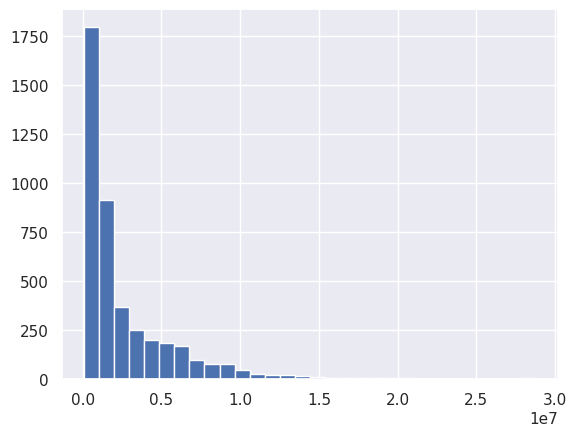

In [279]:
print(car_info_fs['target_1'].isnull().sum())
car_info_fs['target_1'].hist(bins=30)

In [280]:
# cols = [c for c in car_info_fs.columns if c not in res_train_df.columns]
# sns.pairplot(data=car_info_fs[cols].sample(500), corner=True, hue='target_2');

In [281]:
# car_info_fs.columns

# car_info_fs['car_id'].value_counts().hist()

# car_info_fs[car_info_fs['car_id'] == 'F19793670T']
car_info_fs.head()

car_type fuel_type  car_rating  year_to_start  riders      car_id  \
0  economy    petrol        24.4           2015   13740  C16209094m   
1  economy    petrol        22.4           2015   14823  G-1559355l   
2  economy    petrol        22.0           2013   16821  v-1144396k   
3  economy    petrol        19.3           2017   56910  P14360916q   
4  economy    petrol        14.7           2014    9255  b13819346G   

          model      target_1         target_2  year_to_work  ...  \
0    VW Polo VI  1.400433e+06  engine_overheat          2019  ...   
1    VW Polo VI  1.093189e+06      electro_bug          2021  ...   
2    VW Polo VI  3.771622e+06        break_bug          2016  ...   
3  Smart ForTwo  1.778182e+06      another_bug          2016  ...   
4   Skoda Rapid  1.519533e+06       gear_stick          2015  ...   

   user_ride_quality__mean  user_ride_quality__standard_deviation  \
0                10.393611                              12.668658   
1                 3.179968                               5.018077   
2                -6.986245                               9.004079   
3                13.019274                               4.681020   
4                -2.767296                               7.450618   

   user_ride_quality__variance  user_ride_quality__root_mean_square  \
0                   160.494887                            16.386642   
1                    25.181098                             5.940816   
2                    81.073444                            11.396537   
3                    21.911947                            13.835224   
4                    55.511713                             7.947933   

   user_ride_quality__maximum  user_ride_quality__absolute_maximum  \
0                   37.125580                            37.125580   
1                   16.282095                            16.282095   
2                    6.908779                            28.666085   
3                   20.841706                            20.841706   
4                   14.901547                            15.523808   

   user_ride_quality__minimum  user_ride_quality__skewness  \
0                   -8.785830                     0.393184   
1                   -4.797755                     0.485854   
2                  -28.666085                    -0.915174   
3                    0.799420                    -0.731424   
4                  -15.523808                     0.506842   

   user_ride_quality__kurtosis  \
0                    -0.857618   
1                    -0.516331   
2                     0.020181   
3                    -0.343648   
4                    -0.811548   

   user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints  
0                                           0.000000                          
1                                           0.000000                          
2                                           0.000000                          
3                                           0.000000                          
4                                           0.051724                          

[5 rows x 74 columns]

In [282]:
# !pip install catboost -q

In [283]:
from sklearn.model_selection import KFold # k-фолдная валидация
from catboost import Pool, CatBoostClassifier, CatBoostRegressor 
import gc 

gc.collect()

79102

# Разделяем фичи на группы (удаляем килер фичи)

In [284]:
killer_fs_to_drop = ['killer_fs', 'destroy_degree_max', 'work_type_crit_q', 'worker_low_exp', 
                     'refuel_check_count', 'repair_mean', 'repair_count', 'ride_distance_sum']

drop_features = ['car_id', 'target_1', 'target_2', 'real_slope'] #+ killer_fs_to_drop
targets = ['target_2']  # target_1
cat_features = ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']

filtered_features = [i for i in car_info_fs.columns if (i not in targets and i not in drop_features)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
# print('filtered_features', filtered_features)
# print('num_features', num_features)
print('targets', targets)

for c in cat_features:
    car_info_fs[c] = car_info_fs[c].astype(str)

cat_features ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']
targets ['target_2']


In [285]:
!pip install iterative-stratification >> None 

In [286]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def make_multi_target(df, target = 'target_2'):
    
    if target in df.columns:
    
        one_hot = pd.get_dummies(df[target])
        df = df.drop(target, axis = 1)
        df = df.join(one_hot)
    
    return df


def create_folds(data, num_splits=3, targets = [0, 1, 2, 4]):
    if num_splits > 1:
        data['kfold'] = -1
        X = data
        y = data[targets]
        mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

        for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
            data.loc[val_,'kfold'] = fold
    else:
        data.loc[:,'kfold'] = 0
        
    return data

kfolds = 4

targets = car_info.target_2.unique()
# car_info_fs = make_multi_target(car_info_fs, target = 'target_2')
# car_info_fs = create_folds(car_info_fs, num_splits=kfolds, targets = targets)

# car_info_fs = (car_info_fs
      # .pipe(make_multi_target, target = 'target_2')
      # .pipe(create_folds, num_splits = kfolds, targets = targets)
     # )

car_info_fs.head()

car_type fuel_type  car_rating  year_to_start  riders      car_id  \
0  economy    petrol        24.4           2015   13740  C16209094m   
1  economy    petrol        22.4           2015   14823  G-1559355l   
2  economy    petrol        22.0           2013   16821  v-1144396k   
3  economy    petrol        19.3           2017   56910  P14360916q   
4  economy    petrol        14.7           2014    9255  b13819346G   

          model      target_1         target_2  year_to_work  ...  \
0    VW Polo VI  1.400433e+06  engine_overheat          2019  ...   
1    VW Polo VI  1.093189e+06      electro_bug          2021  ...   
2    VW Polo VI  3.771622e+06        break_bug          2016  ...   
3  Smart ForTwo  1.778182e+06      another_bug          2016  ...   
4   Skoda Rapid  1.519533e+06       gear_stick          2015  ...   

   user_ride_quality__mean  user_ride_quality__standard_deviation  \
0                10.393611                              12.668658   
1                 3.179968                               5.018077   
2                -6.986245                               9.004079   
3                13.019274                               4.681020   
4                -2.767296                               7.450618   

   user_ride_quality__variance  user_ride_quality__root_mean_square  \
0                   160.494887                            16.386642   
1                    25.181098                             5.940816   
2                    81.073444                            11.396537   
3                    21.911947                            13.835224   
4                    55.511713                             7.947933   

   user_ride_quality__maximum  user_ride_quality__absolute_maximum  \
0                   37.125580                            37.125580   
1                   16.282095                            16.282095   
2                    6.908779                            28.666085   
3                   20.841706                            20.841706   
4                   14.901547                            15.523808   

   user_ride_quality__minimum  user_ride_quality__skewness  \
0                   -8.785830                     0.393184   
1                   -4.797755                     0.485854   
2                  -28.666085                    -0.915174   
3                    0.799420                    -0.731424   
4                  -15.523808                     0.506842   

   user_ride_quality__kurtosis  \
0                    -0.857618   
1                    -0.516331   
2                     0.020181   
3                    -0.343648   
4                    -0.811548   

   user_ride_quality__percentage_of_reoccurring_datapoints_to_all_datapoints  
0                                           0.000000                          
1                                           0.000000                          
2                                           0.000000                          
3                                           0.000000                          
4                                           0.051724                          

[5 rows x 74 columns]

In [287]:
# car_info_fs.columns

In [288]:
# car_info_fs.columns.tolist()

# Catboost Classifier

In [289]:
# targets_dict = {'nothing' : 0, 'soft_1' : 1, 'soft_2' : 2, 'critical' : 4}
# f_map = lambda x: targets_dict.get(x, x)
# car_info_fs['target_2'] = car_info_fs['target_2'].map(f_map)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

In [290]:
target_dict  = {
    'engine_ignition' : 0,
    'engine_fuel' : 4,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)


In [291]:
# {'Recall:class=6': 1.0, 
#  'Recall:class=5': 1.0, 
#  'Recall:class=3': 1.0, 
#  'Recall:class=8': 1.0, 
#  'Recall:class=2': 1.0, 
#  'Recall:class=7': 1.0, 
#  'Recall:class=1': 1.0, 
 
#  'Recall:class=0': 0.98, 
#  'Recall:class=4': 0.9642857142857143,

 
#  'AUC:type=Mu': 0.9996575516171381, 
#  'MultiClass': 0.060581287801266835, 'Accuracy': 0.984}



In [292]:


# engine_overheat electro_bug gear_stick another_bug

In [293]:
# [c for c in filtered_features if c in best_fs]

features_gr = {
    'group_1' : ['car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'model', 'year_to_work',
                 'work_type_moda','work_type_seconde_moda',],
    
    'group_2' : ['user_ride_quality__sum_values','user_ride_quality__median','user_ride_quality__mean','user_ride_quality__standard_deviation',
     'user_ride_quality__variance','user_ride_quality__root_mean_square','user_ride_quality__maximum','user_ride_quality__absolute_maximum',
     'user_ride_quality__minimum','user_ride_quality__skewness','user_ride_quality__kurtosis'],
    
    
    'group_3' : ['deviation_normal__sum_values','deviation_normal__median','deviation_normal__mean','deviation_normal__standard_deviation',
     'deviation_normal__variance','deviation_normal__root_mean_square','deviation_normal__maximum','deviation_normal__absolute_maximum',
     'deviation_normal__minimum','deviation_normal__skewness','deviation_normal__kurtosis','deviation_normal__percentage_of_reoccurring_datapoints_to_all_datapoints'],
    
    
    'group_4' : ['worker_count','destroy_degree_max','destroy_degree_sum','work_duration_mean','work_duration_max','work_type_nuniq',
                 # 'work_type_moda','work_type_seconde_moda',
     'work_type_crit_perc_q','work_type_crit_q','worker_experience_mean','worker_low_exp'],
    
    
    'group_5' : ['refuel_reparking_mean','refuel_mean','reparking_mean','repair_mean','refuel_check_mean', 'refuel_reparking_count',
                 'refuel_count','reparking_count','repair_count','refuel_check_count'],
    
    
    'group_6' : ['ride_duration_sum','ride_distance_sum',
                 'speed_avg_mean','speed_max_mean','speed_max_q',
                 'speed_max_max', 'user_time_accident_mean',
                 # 'user_time_accident_max',
                 'user_rating_min','user_rides_min','crit_low_r'],
    
    'group_6_2' : ['user_time_accident_max'],
    
    'group_7' : ['killer_fs'],
    
    
    'group_8' : ['nan_sum'],
    
    'group_9' : ['high_sum'], 
    
    'group_10' : ['mean_ride_cost'],
    
    'group_11' : ['nan_speed_max']
}
    
    
# features_gr
    
cat_features = ['car_type', 'fuel_type', 'model']
cat_features = ['car_type', 'fuel_type', 'model', 'work_type_moda', 'work_type_seconde_moda']

In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

from sklearn.model_selection import train_test_split


random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

# # Тренд взависимости от Таргета
# C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
ignored_features = []#['car_rating', 'model']
ignored_features_dict = {}
filtered_features = []
for num_i, (gr, fs) in enumerate(features_gr.items()):
    
    
    filtered_features += fs# ignored_features+=[fs]
    
    print(gr, len(fs), 'total: ', len(filtered_features))
    
    X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
    y = car_info_fs[targets]#.copy()

    X, test_data, y, y_data = train_test_split(X, y, stratify=y.values, test_size=0.45, random_state = 7575,
                                              )
    
    test_data['target_2'] = y_data
    test_data.to_csv('../data/test_data.csv', index=False)
    
    
    # print(test_data.shape, y_test.shape)

    
    # print('ignored_features', len(ignored_features))
    scores = []
    for train_index, test_index in kf.split(X):

        # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
        # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

        print(X_train.shape, y_train.shape)
        clf = CatBoostClassifier(iterations = 3500,
                              # loss_function = 'MultiLogloss',
                              custom_metric =['Recall', 'AUC', 'Accuracy'],
                              loss_function='MultiClass',
                              # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
    #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cat_features = cat_features,
                              random_seed=42,                          
    #                           'learning_rate': 0.05953207713558619,
                              colsample_bylevel =  0.09874152157026818,
                              subsample = 0.9563761143682146,
    #                           l2_leaf_reg = 9.178962968420354,
                              min_data_in_leaf = 243,
                              bootstrap_type='Bernoulli',
                             ignored_features = ignored_features,
                              max_bin = 187,
                              task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=5)# + kfold*10 )

        clfs.append(clf)

        # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = False, use_best_model = True, plot = False)
        # scores.append(clf.best_score_['validation']['MultiClass'])
        print(clf.best_score_['validation'])
        scores.append(np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16'))
        
                  
    # ignored_features_dict[num_i] = np.mean(scores)
    print('\n', 'score --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))
    
    y_pred = np.zeros((test_data.shape[0], 9))
    scores = []
    for n, clf in enumerate(clfs):
        y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
        scores.append(clf.best_score_['validation']['Accuracy'])
    #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

    y_pred /= N
    y_pred = y_pred.argmax(axis=1)
    acc_score = np.mean(y_pred == y_data[targets].values.reshape(1, -1)[0], dtype = 'float16')
    print('', 'auc score', acc_score, 'vs', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'),'\n')
    
    
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
# scores = []
# for n, clf in enumerate(clfs):
#     # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
#     scores.append(clf.best_score_['validation']['MultiClass'])
# #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# # y_pred /= N
# print('mean MultiLogloss', np.mean(scores))

num folds 3
group_1 9 total:  9
(1558, 9) (1558, 1)


iteritems is deprecated and will be removed in a future version. Use .items instead.


{'Recall:class=6': 0.3, 'Recall:class=5': 0.15841584158415842, 'Recall:class=3': 0.07526881720430108, 'Recall:class=0': 0.01098901098901099, 'Recall:class=8': 0.24691358024691357, 'Recall:class=2': 0.12359550561797752, 'Recall:class=7': 0.0, 'AUC:type=Mu': 0.5929356294133572, 'Recall:class=1': 0.2631578947368421, 'Recall:class=4': 1.0, 'MultiClass': 2.1725597849886813, 'Accuracy': 0.13735558408215662}
(1558, 9) (1558, 1)
{'Recall:class=6': 0.011111111111111112, 'Recall:class=5': 0.12903225806451613, 'Recall:class=3': 0.19791666666666666, 'Recall:class=0': 0.09195402298850575, 'Recall:class=8': 0.02197802197802198, 'Recall:class=2': 0.12941176470588237, 'Recall:class=7': 0.0, 'AUC:type=Mu': 0.5389251635291491, 'Recall:class=1': 1.0, 'Recall:class=4': 0.010309278350515464, 'MultiClass': 2.1889387682972155, 'Accuracy': 0.11810012836970475}
(1558, 9) (1558, 1)
{'Recall:class=6': 0.03296703296703297, 'Recall:class=5': 1.0, 'Recall:class=3': 0.5227272727272727, 'Recall:class=0': 0.1363636363

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


{'Recall:class=6': 0.2111111111111111, 'Recall:class=5': 0.18811881188118812, 'Recall:class=3': 0.5698924731182796, 'Recall:class=0': 0.23076923076923078, 'Recall:class=8': 0.09876543209876543, 'Recall:class=2': 0.11235955056179775, 'Recall:class=7': 0.5, 'AUC:type=Mu': 0.7193167809675921, 'Recall:class=1': 0.5368421052631579, 'Recall:class=4': 1.0, 'MultiClass': 1.9906510211666442, 'Accuracy': 0.20282413350449294}
(1558, 20) (1558, 1)
{'Recall:class=6': 0.3, 'Recall:class=5': 0.22580645161290322, 'Recall:class=3': 0.34375, 'Recall:class=0': 0.20689655172413793, 'Recall:class=8': 0.10989010989010989, 'Recall:class=2': 0.1411764705882353, 'Recall:class=7': 0.5344827586206896, 'AUC:type=Mu': 0.7295637276842208, 'Recall:class=1': 1.0, 'Recall:class=4': 0.1134020618556701, 'MultiClass': 1.9557289531148, 'Accuracy': 0.20667522464698332}
(1558, 20) (1558, 1)
{'Recall:class=6': 0.10989010989010989, 'Recall:class=5': 1.0, 'Recall:class=3': 0.7045454545454546, 'Recall:class=0': 0.09090909090909

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


{'Recall:class=6': 0.6777777777777778, 'Recall:class=5': 0.38613861386138615, 'Recall:class=3': 0.8709677419354839, 'Recall:class=0': 0.31868131868131866, 'Recall:class=8': 0.5061728395061729, 'Recall:class=2': 0.39325842696629215, 'Recall:class=7': 0.6833333333333333, 'AUC:type=Mu': 0.922404586169704, 'Recall:class=1': 0.6736842105263158, 'Recall:class=4': 1.0, 'MultiClass': 1.3327792719490865, 'Accuracy': 0.49165596919127086}
(1558, 32) (1558, 1)
{'Recall:class=6': 0.7444444444444445, 'Recall:class=5': 0.5053763440860215, 'Recall:class=3': 0.6145833333333334, 'Recall:class=0': 0.4942528735632184, 'Recall:class=8': 0.4175824175824176, 'Recall:class=2': 0.3764705882352941, 'Recall:class=7': 0.4482758620689655, 'AUC:type=Mu': 0.9223857003537188, 'Recall:class=1': 1.0, 'Recall:class=4': 0.29896907216494845, 'MultiClass': 1.339514788813497, 'Accuracy': 0.47881899871630296}
(1558, 32) (1558, 1)
{'Recall:class=6': 0.6593406593406593, 'Recall:class=5': 1.0, 'Recall:class=3': 0.875, 'Recall:c

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


{'Recall:class=6': 0.6888888888888889, 'Recall:class=5': 0.6534653465346535, 'Recall:class=3': 0.7634408602150538, 'Recall:class=0': 0.945054945054945, 'Recall:class=8': 1.0, 'Recall:class=2': 0.47191011235955055, 'Recall:class=7': 0.65, 'AUC:type=Mu': 0.9698568593951113, 'Recall:class=1': 0.7052631578947368, 'Recall:class=4': 0.6835443037974683, 'MultiClass': 0.8125660317210839, 'Accuracy': 0.6803594351732991}
(1558, 42) (1558, 1)
{'Recall:class=6': 0.7777777777777778, 'Recall:class=5': 0.6989247311827957, 'Recall:class=3': 0.7395833333333334, 'Recall:class=0': 0.9195402298850575, 'Recall:class=8': 0.989010989010989, 'Recall:class=2': 0.5176470588235295, 'Recall:class=7': 0.5344827586206896, 'AUC:type=Mu': 0.9740406260204342, 'Recall:class=1': 0.7439024390243902, 'Recall:class=4': 0.5670103092783505, 'MultiClass': 0.7839386869252831, 'Accuracy': 0.6880616174582799}
(1558, 42) (1558, 1)
{'Recall:class=6': 0.6703296703296703, 'Recall:class=5': 0.7125, 'Recall:class=3': 0.863636363636363

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

{'Recall:class=6': 0.6777777777777778, 'Recall:class=5': 0.6039603960396039, 'Recall:class=3': 0.7311827956989247, 'Recall:class=0': 0.8461538461538461, 'Recall:class=8': 1.0, 'Recall:class=2': 0.4943820224719101, 'Recall:class=7': 0.6166666666666667, 'AUC:type=Mu': 0.9700899830892911, 'Recall:class=1': 0.6842105263157895, 'Recall:class=4': 0.6582278481012658, 'MultiClass': 0.8196651135436809, 'Accuracy': 0.6726572528883183}
(1558, 52) (1558, 1)
{'Recall:class=6': 0.7666666666666667, 'Recall:class=5': 0.7096774193548387, 'Recall:class=3': 0.7708333333333334, 'Recall:class=0': 0.9425287356321839, 'Recall:class=8': 0.978021978021978, 'Recall:class=2': 0.5647058823529412, 'Recall:class=7': 0.4827586206896552, 'AUC:type=Mu': 0.9723348930729758, 'Recall:class=1': 0.7317073170731707, 'Recall:class=4': 0.5463917525773195, 'MultiClass': 0.8086230870339736, 'Accuracy': 0.6906290115532734}
(1558, 52) (1558, 1)
{'Recall:class=6': 0.6593406593406593, 'Recall:class=5': 0.725, 'Recall:class=3': 0.82

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

{'Recall:class=6': 0.9555555555555556, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9550561797752809, 'Recall:class=7': 0.9166666666666666, 'AUC:type=Mu': 0.9994410408694124, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.09746660638527907, 'Accuracy': 0.9794608472400513}
(1558, 62) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 0.989010989010989, 'Recall:class=2': 1.0, 'Recall:class=7': 0.8103448275862069, 'AUC:type=Mu': 0.998740685055804, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.09250814751036202, 'Accuracy': 0.9768934531450578}
(1558, 62) (1558, 1)
{'Recall:class=6': 0.978021978021978, 'Recall:class=5': 1.0, 'Recall:class=3': 0.9886363636363636, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.967391304347826, 'Recall:class=7': 0.7719298245614035, 'AUC:type=Mu': 0.9984576566559732, 'Recall:cl

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

{'Recall:class=6': 0.9555555555555556, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9887640449438202, 'Recall:class=7': 0.9166666666666666, 'AUC:type=Mu': 0.9993969762560471, 'Recall:class=1': 0.968421052631579, 'Recall:class=4': 1.0, 'MultiClass': 0.07719306364093229, 'Accuracy': 0.9833119383825417}
(1558, 63) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 1.0, 'Recall:class=7': 0.8103448275862069, 'AUC:type=Mu': 0.9987501168115129, 'Recall:class=1': 0.9878048780487805, 'Recall:class=4': 1.0, 'MultiClass': 0.08894459821039839, 'Accuracy': 0.9807445442875481}
(1558, 63) (1558, 1)
{'Recall:class=6': 0.978021978021978, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9891304347826086, 'Recall:class=7': 0.8070175438596491, 'AUC:type=Mu': 0.998710720402201, 'Recall:c

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

{'Recall:class=6': 0.9666666666666667, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9887640449438202, 'Recall:class=7': 0.9666666666666667, 'AUC:type=Mu': 0.9997448107229564, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.05078942000433137, 'Accuracy': 0.9871630295250321}
(1558, 64) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 0.967032967032967, 'Recall:class=2': 0.9882352941176471, 'Recall:class=7': 0.7931034482758621, 'AUC:type=Mu': 0.9988992882093856, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.07884974664452646, 'Accuracy': 0.9730423620025674}
(1558, 64) (1558, 1)
{'Recall:class=6': 0.967032967032967, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9891304347826086, 'Recall:class=7': 0.8596491228070176, 'AUC:type=Mu': 0.9992057058125846, 'Recall:

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

(1558, 65) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9775280898876404, 'Recall:class=7': 0.9666666666666667, 'AUC:type=Mu': 0.9997362762920616, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.04679101961387421, 'Accuracy': 0.9897304236200257}
(1558, 65) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 1.0, 'Recall:class=7': 0.7758620689655172, 'AUC:type=Mu': 0.9987150733576302, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.0755588713018302, 'Accuracy': 0.975609756097561}
(1558, 65) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9891304347826086, 'Recall:class=7': 0.8245614035087719, 'AUC:type=Mu': 0.9993100187211704, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, '

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

(1558, 66) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9887640449438202, 'Recall:class=7': 0.95, 'AUC:type=Mu': 0.9997119098203269, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.05966601756141235, 'Accuracy': 0.9897304236200257}
(1558, 66) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 0.989010989010989, 'Recall:class=2': 1.0, 'Recall:class=7': 0.7931034482758621, 'AUC:type=Mu': 0.99852458375686, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, 'MultiClass': 0.09475497925763017, 'Accuracy': 0.9743260590500642}
(1558, 66) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9891304347826086, 'Recall:class=7': 0.8421052631578947, 'AUC:type=Mu': 0.9992707753088427, 'Recall:class=1': 1.0, 'Recall:class=4': 1.0, '

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

 auc score 0.9785 vs 0.7075 0.3184 

group_10 1 total:  67
(1558, 67) (1558, 1)


iteritems is deprecated and will be removed in a future version. Use .items instead.


{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 1.0, 'Recall:class=2': 0.9887640449438202, 'Recall:class=7': 0.9666666666666667, 'AUC:type=Mu': 0.9997811560273505, 'Recall:class=1': 0.9894736842105263, 'Recall:class=4': 1.0, 'MultiClass': 0.04163584334420907, 'Accuracy': 0.9922978177150192}
(1558, 67) (1558, 1)
{'Recall:class=6': 1.0, 'Recall:class=5': 1.0, 'Recall:class=3': 1.0, 'Recall:class=0': 1.0, 'Recall:class=8': 0.978021978021978, 'Recall:class=2': 1.0, 'Recall:class=7': 0.7931034482758621, 'AUC:type=Mu': 0.9987056416019213, 'Recall:class=1': 0.975609756097561, 'Recall:class=4': 1.0, 'MultiClass': 0.0770944401533179, 'Accuracy': 0.9717586649550706}
(1558, 67) (1558, 1)


In [299]:
# car_info_fs
car_info[car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])].to_csv('../data/car_test.csv', index=False)
car_info[~car_info['car_id'].isin(car_info_fs.loc[test_data.index]['car_id'])].to_csv('../data/car_train.csv', index=False)

In [ ]:
y_pred.shape, y_test.shape 
# y_test[targets].values.reshape(1, -1)[0]
# y_test
# y_test[targets].values.reshape(1, -1)[0]

In [222]:
# y_pred

y_test[targets].nunique()

target_2    9
dtype: int64

In [223]:
# y_test[targets].values.reshape(1, -1)[0]

In [224]:
1/9

0.1111111111111111

In [225]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# def chect_test(X_test, y_test, clfs):
#     # массив для записи финального результата
#     y_pred = np.zeros((X_test.shape[0], 7))
#     scores = {'MultiClass':[], 'Precision' : [], 'Recall' : []}
#     for n, clf in enumerate(clfs):
#         y_pred += clf.predict_proba(X_test[filtered_features])#[:,1]
#         scores['MultiClass'].append(clf.best_score_['validation']['MultiClass'])

#     y_pred =  np.argmax(y_pred, axis=1)

#     cm = confusion_matrix(y_test['target_2'], y_pred, normalize='all')
#     cmd = ConfusionMatrixDisplay(cm) #, display_labels=sorted(y_test['crop'].unique().tolist())
#     cmd.plot(xticks_rotation=45, cmap = 'viridis_r');

# chect_test(X_test, y_test, clfs[-1:])
y_test['target_2'].shape#.value_counts()
y_pred.shape

(1913,)

Всего признаков 68 Усреднее по 3-ти моделям: 
На график нанесено топ-100 признаков


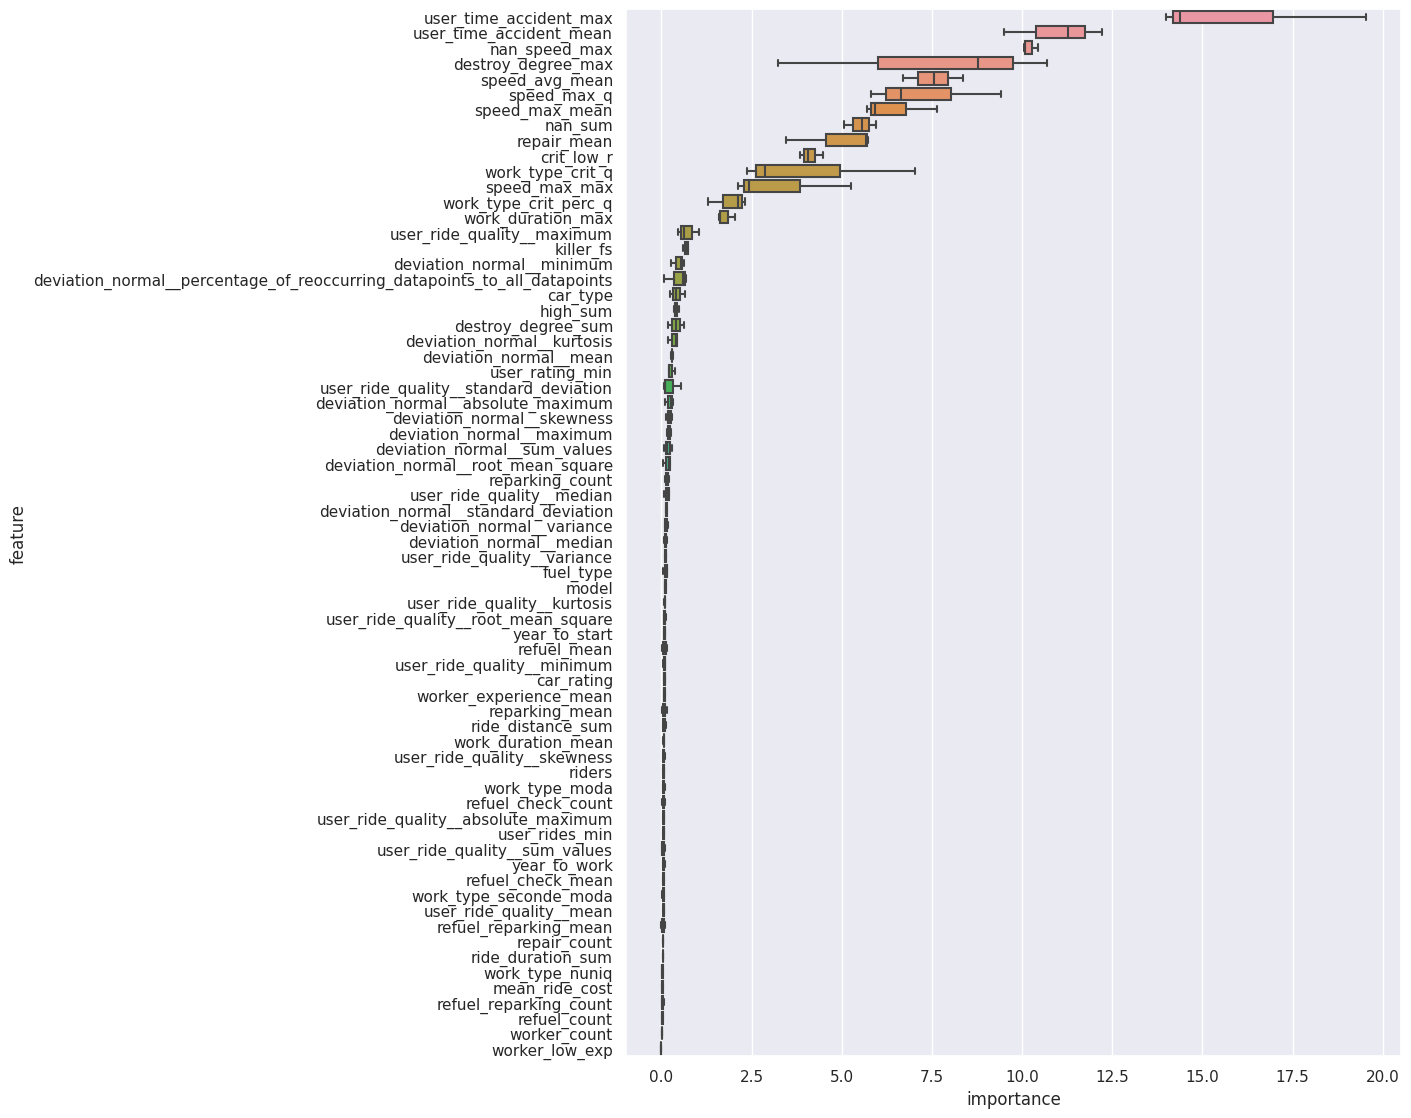

In [226]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore'), clfs[-
                                                                                                           3:], 0.20, top_n=100)


In [227]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python -q

In [228]:
!pip install shap -q

In [229]:
# import catboost
# from catboost import *

import shap

shap.initjs()

iteritems is deprecated and will be removed in a future version. Use .items instead.


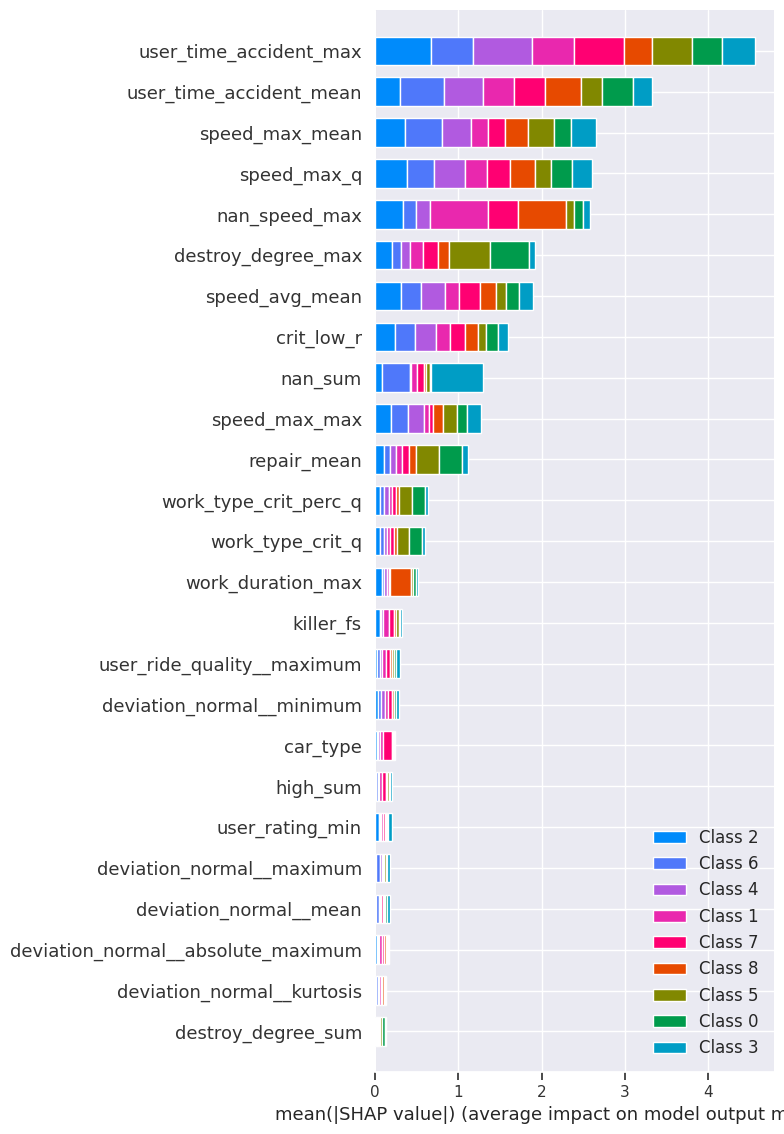

In [230]:
explainer = shap.TreeExplainer(clfs[-1])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train, max_display = 25)

In [231]:
from catboost.utils import get_confusion_matrix
import seaborn
# from sklearn.metrics import confusion_matrix


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
confusion_matrix = get_confusion_matrix(clf, train_dataset, thread_count=-1)

In [232]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

# target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)

# car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

y_test['target_2'] = y_test['target_2'].apply(f)
y_test.value_counts()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


target_2
1           101
4            94
2            92
6            91
0            88
3            88
8            88
5            80
7            57
dtype: int64

In [233]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(y_test, cbc_pred, normalize='all')
# cmd = ConfusionMatrixDisplay(cm, display_labels=target_dict.keys())
# cmd.plot(xticks_rotation='45', cmap = 'viridis_r');


In [234]:
!pip install pandas_ml >> None

In [235]:
# from pandas_ml import ConfusionMatrix
# import matplotlib.pyplot as plt

# cm = ConfusionMatrix(y_test, y_pred)
# cmd.plot()

In [236]:
y_test['target_2'].value_counts()

1    101
4     94
2     92
6     91
0     88
3     88
8     88
5     80
7     57
Name: target_2, dtype: int64

# Catboost Regressor

In [237]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['target_2']
X = car_info_fs[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = car_info_fs[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

best_fs = ['ride_distance_sum','destroy_degree_sum','destroy_degree_max','riders','worker_experience_mean',
    'worker_low_exp','work_duration_mean','destroy_degree_max','work_type_crit_q','killer_fs',
    'repair_count','refuel_check_count','repair_mean','repair_mean','work_duration_max',
    'work_type_nuniq','user_time_accident_max','user_rating_min','user_rides_min']

# # Тренд взависимости от Таргета
# C = 1 # (2 - x.real_slope)*(2 + (x['deviation_normal__linear_trend__attr_"slope"'])**2)
ignored_features = ['car_rating', 'main_city', 'riders']
ignored_features_dict = {}
for num_i, fs in enumerate(best_fs):
    ignored_features+=[fs]
    scores = []
    for train_index, test_index in kf.split(X):

        # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
        # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

        print(X_train.shape, y_train.shape)
        clf = CatBoostRegressor(iterations = 30_000,
                              loss_function = 'MAE',
                              eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
    #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                              cat_features = cat_features,
                              random_seed=42,                          
    #                           'learning_rate': 0.05953207713558619,
                              colsample_bylevel =  0.09874152157026818,
                              subsample = 0.9563761143682146,
    #                           l2_leaf_reg = 9.178962968420354,
                              min_data_in_leaf = 243,
                              max_bin = 187,
                              ignored_features = ignored_features,
                              task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                              early_stopping_rounds=100)# + kfold*10 )


        clfs.append(clf)

        # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = False, use_best_model = True, plot = False)
        scores.append(clf.best_score_['validation']['MAPE'])
        # scores.append(np.mean([v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]))
        print('score', scores[-1])
    
    print('------------', np.mean(scores))
    ignored_features_dict[num_i] = np.mean(scores)
    
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# массив для записи финального результата
# y_pred = np.zeros((test_data.shape[0], 10))
scores = []
for n, clf in enumerate(clfs):
    # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MAPE'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

num folds 3
(2833, 68) (2833, 1)


iteritems is deprecated and will be removed in a future version. Use .items instead.


CatBoostError: catboost/libs/data/feature_names_converter.h:28: String main_city is not a feature name

In [ ]:
# [v for k, v in clfs[0].best_score_['validation'].items() if 'Recall' in k]
clfs[0].best_score_['validation']

# Catboost Regressor

In [ ]:
# # print(huge_train_final.columns)
# # huge_train_final = huge_train_final

# random_state = 42
# n_splits = 3 # kfolds
# print('n_fold', n_splits)
# clfs = []

# targets = targets

# X = car_info_fs[filtered_features].fillna(0)#.copy()
# y = car_info_fs[['target_1']].fillna(car_info_fs['target_1'].mean())#.copy()

# # параметры валидации, обучение будет идти на 6 X n_splits фолдах

# kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
# N = len(kFold_random_state)*n_splits

# kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# for train_index, test_index in kf.split(X):
        
# #     X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
# #     y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

#     X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
# #     train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
# #     eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
#     print(X_train.shape, y_train.shape)
#     clf = CatBoostRegressor(iterations = 30_000,
#                           loss_function = 'MAE',
#                           eval_metric = 'MAPE', #'AUC:hints=skip_train~false',
# #                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#                           cat_features = cat_features,
#                           random_seed=42,                          
# #                           'learning_rate': 0.05953207713558619,
#                           colsample_bylevel =  0.09874152157026818,
#                           subsample = 0.9563761143682146,
# #                           l2_leaf_reg = 9.178962968420354,
#                           min_data_in_leaf = 243,
#                           max_bin = 187,
#                           task_type='CPU', #auto_class_weights = 'SqrtBalanced',
#                           early_stopping_rounds=2180)# + kfold*10 )
    
#     clfs.append(clf)

#     clf.fit(X_train, y_train, eval_set=(X_test, y_test),
# #     clf.fit(train_dataset, eval_set=eval_dataset,
#             verbose = 500, use_best_model = True, plot = False)
# #     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))
        
        
# assert len(clfs) == N

# # массив для записи финального результата
# # y_pred = np.zeros((test_data.shape[0], 10))
# scores = []
# for n, clf in enumerate(clfs):
#     # y_pred += clf.predict_proba(test_data[filtered_features])#[:,1]
#     scores.append(clf.best_score_['validation']['MAE'])
# #     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# # y_pred /= N
# print('mean MAE', np.mean(scores))

In [ ]:
# clf.best_score_['validation']

# Feature Importance

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(car_info_fs[filtered_features], clfs[3:6], height = 0.20, top_n = 70)


In [ ]:
explainer = shap.TreeExplainer(clfs[2])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)
# shap_values

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train)

In [ ]:
# plt.figure(figsize = (20, 20));
shap.dependence_plot("riders", shap_values, X_train)


# Смотрим на остатки

In [ ]:
cbr_prediction = clfs[0].predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted values"])
df_pred["Actual values"] =  y_test['target_1'].values

sns.relplot(data = df_pred, aspect = 4, kind = 'line')

In [ ]:
df_pred['diff'] = df_pred["Actual values"] - df_pred["Predicted values"]

sns.relplot(data = df_pred['diff'], aspect = 4, kind = 'line')

In [ ]:
# sns.realplot(data = X[])


# Тест на логику и гипотезы из таблицы

In [ ]:
target_dict  = {'engine_ignition' : 0,
    'another_bug' : 1,
    'engine_overheat' : 2,
    'gear_stick' : 3,
    'engine_fuel' : 4,
    'engine_check' : 5,
    'break_bug' : 6,
    'wheel_shake' : 7,
    'electro_bug' : 8}

target_dict = {v:k for k, v in target_dict.items()}

f = lambda x: target_dict.get(x, x)
car_info_fs['target_2'] = car_info_fs['target_2'].apply(f)

In [ ]:
# sns.set()
plt.figure(figsize = (20, 6))
sns.histplot(data = car_info_fs, hue = 'target_2', x = 'target_1', bins=50);

In [ ]:
sns.displot(data = car_info_fs, x = 'target_2', y = 'target_1', bins=50,
            aspect=5, height=10);

In [ ]:
car_info_fs

In [ ]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
cluster_labels = clusterer.fit_predict(X_embedded)

In [ ]:
Снизить разерность датасета, используя метод t-SNE

In [ ]:
from sklearn.manifold import TSNE


# Вспомогатльеные фрагменты кода
# data_x_y = TSNE(n_components=2, learning_rate='auto',
#                 random_state=22, n_jobs=-1, 
#                 init='random').fit_transform(df)

In [ ]:

#Вспомогатльеные фрагменты кода
# plt.figure(figsize=(12,9))
# plt.scatter(data_x, data_y, c=cluster_labels, cmap ='Set3', s=5)
# plt.scatter(data_x, data_y, c=y_blobs, s=1, cmap ='Set3')
# plt.legend(cluster_labels)
# plt.show()

In [ ]:
# TODO
- Догенерить базововую часть датасета
- Пошерить доступ на ноутбуки
- Гегерировать фичи уже при написании ноутбуков
- Утвердить программу 
- 

# Открываем файлы и смотрим, все ли в порядке

In [ ]:
# https://www.projectpro.io/recipes/upload-files-to-google-drive-using-python

# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB/view?usp=share_link'
# url = 'https://drive.google.com/file/d/1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-/view?usp=share_link'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]

url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'  # rides_info
rides_info = pd.read_csv(url)
rides_info.head().columns

# url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  # car_info
# car_info = pd.read_csv(url)
# car_info.head()

In [ ]:
import pandas as pd

# url = 'https://drive.google.com/file/d/1cGrFMilJtLrPPOTRfH46DX3qvBRnxdUT/view?usp=sharing'
# url ='https://drive.google.com/uc?id=' + url.split('/')[-2]
# url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' # rider_info - информация про водителей
# rider_info = pd.read_csv(url)
# rider_info.head()


In [ ]:
cols = ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'main_city', 'riders', 'year_to_work', 'target_1', 'target_2']
url = 'https://drive.google.com/uc?id=1s_UlUxRszNn24R_cyfS9RWTNaJS2Z8DB'
car_info = pd.read_csv(url)   # car_info - информация про машины с таргетом
car_info[cols]['target_2'].nunique()

In [ ]:
url = 'https://drive.google.com/uc?id=1eqFIZCJTkXY-PsTeS-uz_DousIH3XQu-'  
rides_info = pd.read_csv(url) # rides_info - информация про поездки
rides_info.drop(['car_rating','killer_fs'], axis=1).head(3)

In [ ]:
cols = ['user_id', 'age', 'sex', 'user_rating', 'user_rides', 'user_time_accident', 'first_ride_date']
url = 'https://drive.google.com/uc?id=1FkwxNT8_vN2pIYoFJx29l4ZhDYBzMamt' 
driver_info = pd.read_csv(url)  # driver_info - информация про водителей
driver_info[cols].head(3)

In [ ]:
cols = ['worker_id', 'car_id', 'work_type', 'destroy_degree', 'work_duration', 'fix_date']
url = 'https://drive.google.com/uc?id=1_UeE8KZmLb50phMoxcVT2hIdzToyVr42' # fix_info - информация про ремонт машин
fix_info = pd.read_csv(url)
fix_info[cols].head(3)

In [ ]:
# !pip install pydrive

In [ ]:
# gauth = GoogleAuth()           
# drive = GoogleDrive(gauth)  

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()           
drive = GoogleDrive(gauth) # 1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b

In [ ]:
upload_file_list = ['../data/fix_info.csv']
for upload_file in upload_file_list:
	gfile = drive.CreateFile({'parents': [{'id': '1hqEuNuaYdXV9D-j_Ctx0TndExJwoc23b'}]})
	# Read file and set it as the content of this instance.
	gfile.SetContentFile(upload_file)
	gfile.Upload() # Upload the file.

In [ ]:
!ls ../data/

In [ ]:
!conda install pycaret

In [ ]:
from pycaret.utils import version
version()